In [1]:
# 引入常用库
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import datetime as dt
import itertools # 迭代器工具

import pysnooper # debug
import pickle
from IPython.core.display import HTML

from jqdata import *
from jqfactor import *
import talib # 技术分析
# 画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('ggplot')

# 忽略报错
import warnings
warnings.filterwarnings("ignore")

# <font color=DarkMagenta>阻力支撑相对强弱概念</font>

在技术分析中，阻力位与支撑位经常被市场参与者提及并给出自己认为 的阻力支撑点位。阻力位与支撑位的概念很容易理解，顾名思义，**支撑位**即:<u>是指标的价格在下跌时可能遇到的支撑，是交易者认为买方力量开始反超卖方使得价格在此止跌或反弹上涨的价位</u>；**阻力位**则<u>是指在标的价格上涨时可 能遇到的压力，是交易者认为卖方力量开始反超买方而使得价格难以继续上涨或就此回调下跌的价位</u>。

## <font color=DarkMagenta>支撑位与阻力位的常用方式</font>

阻力位与支撑位的运用思路大多在突破策略与反转策略中，即如果价格 向上突破阻力位追涨做多，向下突破支撑位杀跌做空；或者在反转策略中如果价格向上接近阻力位做空回调，向下接近支撑位做多反弹。

市场中交易者对于支撑位与阻力位 的使用方式是用其本身的点位当作阈值，或者说是当作一个定值来使用。

1. 布林带上下轨突破策略：若当日收盘价超过布林带（14,2）上轨， 则建仓买入。一直持仓至收盘价低于布林带（14,2）下轨，卖出平仓。

2. 均线策略：若当日收盘价超过 20 日均线，则建仓买入。一直持仓 至收盘价低于 20 日均线，卖出平仓。

**传统均线策略与布林策略的缺点**：在大趋势中可以获取巨额收益；在等待突破时产生的滞后性，这使得它们在震荡行情中会不断亏损。

In [3]:
# 均值与布林策略回测情况

# 以HS300为准
index_id = '000300.XSHG'
# 时间范围设定
start, end = '2005-04-08', '2019-9-30'
# 获取数据
datas = get_price(index_id, start_date=start,
                  end_date=end, fields='close')

# 获取每日成分股权重，后续会使用到


def get_weights(index_id, start, end):
    weight_dic = {}
    tradeList = get_trade_days(start_date=start, end_date=end)
    for trade in tradeList:
        weight_dic[trade] = get_index_weights(index_id, trade)['weight'].values
        print('seccuss', trade.strftime("%Y%m%d"))

    pkl_file = open('weight_dic.pkl', 'wb')
    pickle.dump(weight_dic, pkl_file)
    print('已储存')
    return weight_dic


# 粗略计算手续费
'''
read_dic如果已经调用get_weights则 true,没有则false
手续费：通过指数成分股权重*费率计算
'''


def cal_fee(datas,singal_name='singal',fee=0.006, read_dic=True):

    df = datas
    # 标记买入卖出时点
    singal = df[singal_name]*np.ones(len(df))
    next_singal = df[singal_name].shift(1)*np.ones(len(df))
    pre_singal = df[singal_name].shift(-1)*np.ones(len(df))
    # 确认时点
    df['fee'] = (singal == 1) & (
        (pre_singal < singal) | (singal > next_singal))

    # 手续费采用成分股权重*费率粗略计算
    def _get_weights(x_df,fee):
        trade = x_df.name
        # print(trade.date())
        weights_df = get_index_weights('000300.XSHG', trade.date())
        cost = np.mean(weights_df['weight']*fee) * \
            x_df['fee'].values[0]  # 权重*费率
        return cost

    cond = df['fee'] == True

    # 如果依旧提前下载好了数据
    if read_dic:
        # 读取权重
        pkl_file=open('weight_dic.pkl','rb')
        weight_dic=pickle.load(pkl_file)
        # 权重*费率
        df['cost'] = list(map(lambda x: np.mean(
            weight_dic[x.date()]*fee) if len(weight_dic[x.date()]) != 0 else 0, df.index))*df['fee']
    else:
        cost = df[cond].groupby(level=0).apply(_get_weights,fee=fee)
        df.loc[cond, 'cost'] = cost
        df['cost'] = df['cost'].fillna(0)

    return df

# 风险指标


def risk_table(x_df):
    df = x_df[:-1].copy()
    temp = []
    for cum_name in ['CUM_RET', 'SUB_CUM_RET']:

        # 计算年华收益率
        annual_ret = df[cum_name][-1]**(244/len(df[cum_name])) - 1

        # 计算累计收益率
        cum_ret_rate = df[cum_name][-1] - 1

        # 最大回撤
        max_nv = np.maximum.accumulate(df[cum_name])
        mdd = -np.min(df[cum_name] / max_nv - 1)

        # 夏普
        if cum_name == 'CUM_RET':
            sharpe_ratio = df['RET'].mean()/df['RET'].std()*np.sqrt(250)
        elif cum_name == 'SUB_CUM_RET':
            sharpe_ratio = df['SUB_FEE_RET'].mean()/df['SUB_FEE_RET'].std()*np.sqrt(250)

        temp.append(['{:.2%}'.format(annual_ret), '{:.2%}'.format(
            cum_ret_rate), '{:.2%}'.format(mdd), '{:.2%}'.format(sharpe_ratio)])

    return pd.DataFrame(temp, index=['策略', '策略扣双向费率'], columns=['年华收益率', '累计收益', '最大回撤', '夏普'])

# 均线策略


def MA_Strategy(data):

    df = data
    df['MA20'] = df['close'].rolling(20).mean()  # 计算20日均线
    df['singal'] = df['close'] > df['MA20']  # 生产信号
    df['ret'] = df['close'].pct_change()  # 计算收益率

    # 计算费率(先标记出信号)
    df = cal_fee(df)

    # 计算持仓收益
    # 滞后一期收益：今日收盘计算信号，次日买入
    df['RET'] = df['ret'].shift(-1)*df['singal']

    # 计算扣除双边手续费收益
    df['SUB_FEE_RET'] = df['RET']-df['cost']

    # 策略净值
    df['CUM_RET'] = (1+df['RET']).cumprod()
    df['SUB_CUM_RET'] = (1+df['SUB_FEE_RET']).cumprod()

    # 基准净值
    benchmark = (1+df['ret']).cumprod()

    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(df['CUM_RET'], label='均值策略')
    ax1.plot(df['SUB_CUM_RET'], label='均值策略(扣双边手续费0.6%)')
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('均线策略净值曲线')
    plt.show()

    # 风险报告
    display(HTML(risk_table(df).to_html()))

# 双均线策略


def BBANDS_Strategy(data):

    df = data.copy()

    df['ret'] = df['close'].pct_change()  # 计算收益率
    # 计算布林的上下轨
    upperband, middleband, lowerband = talib.BBANDS(
        df['close'].values, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)

    # 标记信号
    singal = []

    for row in range(len(df)):

        if df.iloc[row].close > upperband[row]:
            singal.append(1)
        else:
            if row != 0:
                if singal[-1] and df.iloc[row].close > lowerband[row]:
                    singal.append(1)
                else:
                    singal.append(0)
            else:
                singal.append(0)

    df['singal'] = singal
    # 计算费率(先标记出信号)
    df = cal_fee(df)

    # 计算持仓收益
    # 滞后一期收益：今日收盘计算信号，次日买入
    df['RET'] = df['ret'].shift(-1)*df['singal']

    # 计算扣除双边手续费收益
    df['SUB_FEE_RET'] = df['RET']-df['cost']

    # 策略净值
    df['CUM_RET'] = (1+df['RET']).cumprod()
    df['SUB_CUM_RET'] = (1+df['SUB_FEE_RET']).cumprod()

    # 基准净值
    benchmark = (1+df['ret']).cumprod()

    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(df['CUM_RET'], label='布林策略')
    ax1.plot(df['SUB_CUM_RET'], label='布林策略(扣双边手续费0.6%)')
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('布林通道策略净值曲线')
    plt.show()

    # 风险报告
    display(HTML(risk_table(df).to_html()))

In [4]:
# 获取权重
#weight_dic=get_weights(index_id, start, end)

In [5]:
# 读取权重
pkl_file=open('weight_dic.pkl','rb')
weight_dic=pickle.load(pkl_file)

<Figure size 432x288 with 0 Axes>

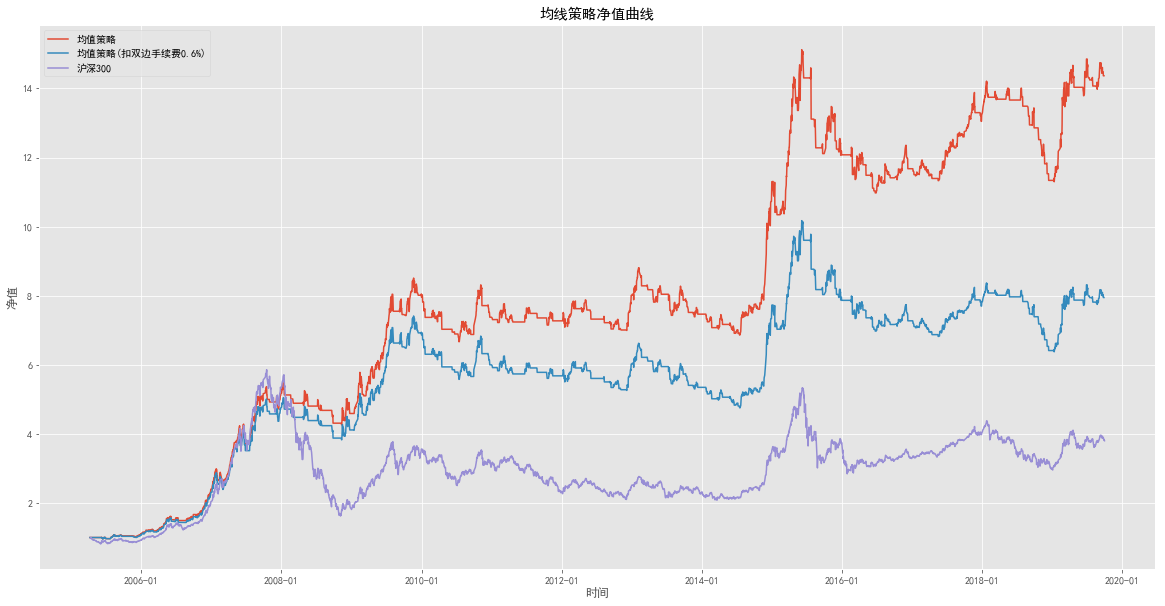

,年华收益率,累计收益,最大回撤,夏普
策略,20.27%,1336.59%,27.41%,113.77%
策略扣双向费率,15.44%,694.71%,37.31%,89.56%


In [6]:
# 均线策略回测
MA_Strategy(datas)

<Figure size 432x288 with 0 Axes>

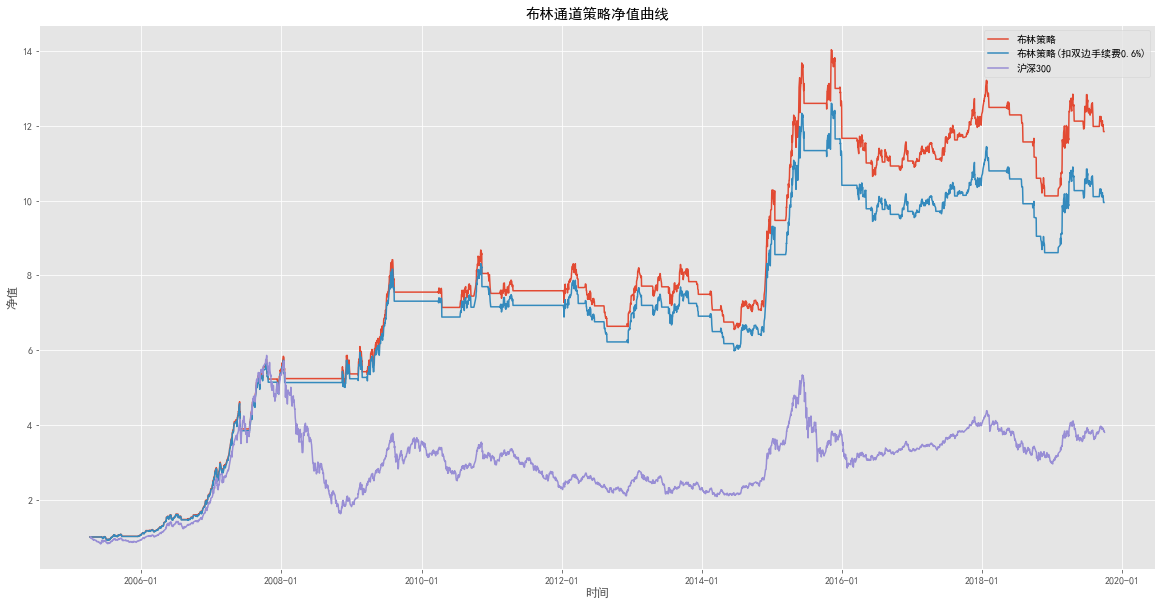

,年华收益率,累计收益,最大回撤,夏普
策略,18.67%,1084.27%,27.87%,109.93%
策略扣双向费率,17.25%,894.67%,31.71%,102.30%


In [7]:
# 布林通道策略回测
BBANDS_Strategy(datas)

## <font color=DarkMagenta>阻力支撑相对强度概念及其与市场状态的对应<font>

传统均线策略都将阻力或者支撑当作一种阈值，**RSRS**不再把阻力位与支撑位当做一个定值，而是<font color=Darkred>**看做一个变量**</font>；阻力位与支撑位实质上反应了交易者对目前市场状态顶底的一种预期判断。这种预期判断极易改变，则表明支撑位或阻力位的强度小，有效性弱；而如果众多交易者预期较为一致、变动不大，则表明支撑位或阻力位强度高，有效性强。

我们按照不同市场状态分类来说明支撑阻力相对强度的应用逻辑： 
1. 市场在上涨牛市中： 如果支撑明显强于阻力，牛市持续，价格加速上涨 如果阻力明显强于支撑，牛市可能即将结束，价格见顶
2. 市场在震荡中： 如果支撑明显强于阻力，牛市可能即将启动 如果阻力明显强于支撑，熊市可能即将启动
3. 市场在下跌熊市中： 如果支撑明显强于阻力，熊市可能即将结束，价格见底如果阻力明显强于支撑，熊市持续，价格加速下跌

## <font color=DarkMagenta>阻力支撑代理变量的定义选择与相对强度的量化</font>

**代理变量**

用相对位置变化程度，即类似<font size=3> $\frac{\delta（high）}{\delta（low）}$</font>的值来描 述支撑位与阻力位的相对强度，即最低价每变动 1 的时候，最高价变动的幅 度。实际上，<font size=3> $\frac{\delta（high）}{\delta（low）}$</font>是连接高低价格平面上的两点 （low[0],high[0]）与（low[1],high[1]）的斜率。由于市场量价本身噪音的存 在，通过两点得到的斜率也包含了太大的噪音。我们考虑通过最近N 个（low， high）的数据点来得到信噪比较高的最高最低价相对变化程度，自然而然的 想法即是使用线性回归。如果我们建立如下般最高价与最低价之间的线性模型：


$$high=\alpha+\beta*low+\epsilon,\ \epsilon\sim(0,\sigma) \tag{1}$$

那么$\beta$ 值就是我们所需要的斜率。其中N的取法不能太小，不然不 能过滤掉足够多的噪音；但也不能太大，因为我们希望得到的是体现目前市 场的支撑阻力相对强度，若取值太大，则滞后性太高。 

1. 当<font color=CornflowerBlue>**斜率值($\beta$)很大**</font>时，支撑强度强于阻力强度。从最高价最低价序列来看，最高价变动比最低价迅速。在上涨牛市中与下跌熊市中很可能以下图中两种 走势体现：在牛市中阻力渐小，上方上涨空间大；在熊市中支撑渐强，下跌
势头欲止。

2. 当<font color=CornflowerBlue>**斜率值($\beta$)很小**</font>时，阻力强度强于支撑强度。从最高价最低价序列来看， 最高价变动比最低价缓慢。在上涨牛市中与下跌熊市中很可能以下图中两种 走势体现：在牛市中阻力渐强，上涨势头渐止；在熊市中支撑渐送，下方下
跌空间渐大。

## <font color=DarkMagenta>阻力支撑相对强度（RSRS）指标构建</font>

在确定阻力与支撑的代理变量以及相对强度的定义之后，我们依此建立 RSRS 指标。一种即是<font color=Darkred>直接利用斜率的本身作为指标值</font>。 <font color=Darkred>**当日斜率指标**</font>的计算方式： 

1. 取前N日的最高价序列与最低价序列。 
2. 将两列数据按式（1）的模型进行OLS 线性回归。
3. 将拟合后的 beta 值作为当日RSRS 斜率指标值。

另一种则为<font color=Darkred>将斜率标准化，取其标准分作为指标值</font>。 当<font color=Darkred>**日标准分指标**</font>的计算方式：

1. 取前M日的斜率时间序列。 
2. 以此样本计算当日斜率的标准分。 
3. 将计算得到的标准分 z 作为当日RSRS标准分指标值。


# <font color=DarkMagenta>RSRS指标择时初步效果</font>

在初步定义RSRS 指标后，我们更关注其在市场择时上的应用效果。这一章 我们将先后试验 RSRS 斜率指标与通过斜率时间序列计算的 RSRS 标准分 指标的择时效果。 

采用的交易框架为：

- 阈值交易逻辑，即当指标值超过某个阈值 S1 时，买入；
- 当指标值穿过另一个阈值S2时，卖出平仓。

## <font color=DarkMagenta>RSRS指标择时策略构建</font>

In [132]:
# 以HS300为准
index_id = '000300.XSHG'
# 时间范围设定
start, end = '2005-04-08', '2019-9-30'
# 获取数据
datas = get_price(index_id, start_date=start,
                  end_date=end, fields=['close', 'high', 'low','volume'])
df = datas.copy()

In [9]:
# 计算RSRS

def Cal_RSRS(df, N):
    df=df.copy()
    # 填充空缺,注意质量填充的是18，t日计算的信号，在T+1日，所以收益不需要在滞后一期
    temp = [np.nan]*N
    
    for row in range(len(df)-N):
        
        y = df['high'][row:row+N]
        x = df['low'][row:row+N]
        
        # 计算系数
        beta = np.polyfit(x, y, 1)[0]
        
        temp.append(beta)
        
    df['RSRS'] = temp
    return df

# 计算基础RSRS
RSRS_df=Cal_RSRS(df,18)

按照阈值交易框架，我们需要确定上下两个阈值。为了能找到比较合理 的阈值，我们观察斜率的历史数据分布（以N=18 计算）：

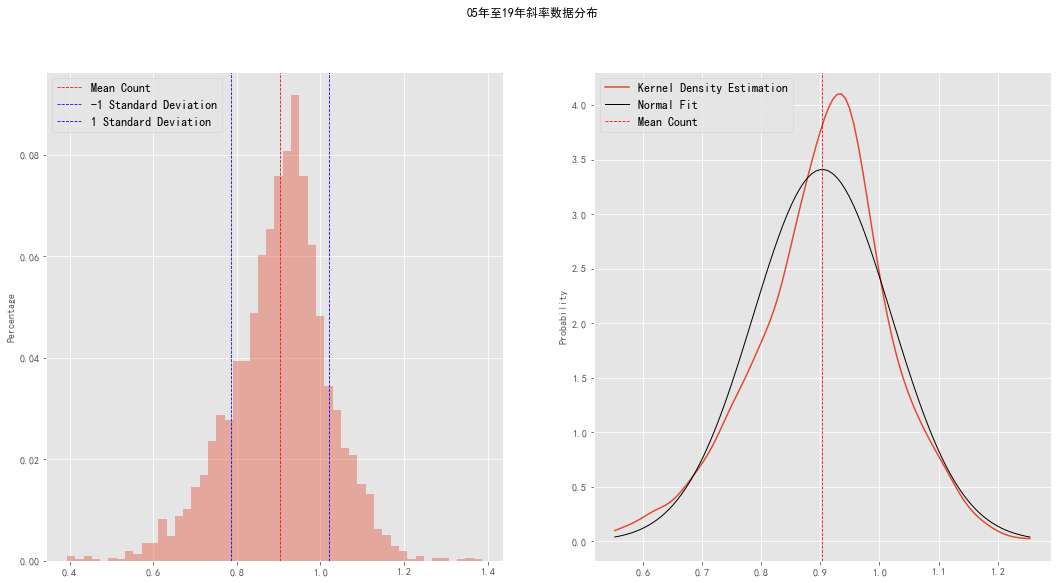

In [10]:
# 统计画图
def stat_depict_plot(df, col,title):
    
    df = df[~df[col].isna()].copy()
    
    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])
    
    plt.style.use('ggplot')
    # 画日对数收益率分布直方图
    fig = plt.figure(figsize=(18, 9))
    plt.suptitle(title)
    v = df[col]
    x = np.linspace(avgRet - 3*stdRet, avgRet + 3*stdRet, 100)
    y = st.norm.pdf(x, avgRet, stdRet)
    kde = st.gaussian_kde(v)

    # plot the histogram
    plt.subplot(121)
    plt.hist(v, 50, weights=np.ones(len(v))/len(v), alpha=0.4)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.axvline(x=avgRet - stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='-1 Standard Deviation')
    plt.axvline(x=avgRet + stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='1 Standard Deviation')
    plt.ylabel('Percentage', fontsize=10)
    plt.legend(fontsize=12)

    # plot the kde and normal fit
    plt.subplot(122)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.plot(x, y, color='black', linewidth=1, label='Normal Fit')
    plt.ylabel('Probability', fontsize=10)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.legend(fontsize=12)
    return plt.show()

stat_depict_plot(RSRS_df,'RSRS','05年至19年斜率数据分布')

In [11]:
# 低阶距统计描述
def stat_depict(df, col, pr=True):
    df = df[~df[col].isna()].copy()
    # 计算总和的统计量
    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])
    if pr:
        print(
            """
        平均数 : %.4f
        中位数 : %.4f
        标准差 : %.4f
        偏度   : %.4f
        峰度   : %.4f
        1 Standard Deviation : %.4f
        -1 Standard Deviation : %.4f
        """ % (avgRet, medianRet, stdRet, skewRet, kurtRet, avgRet+stdRet, avgRet-stdRet)
        )
    else:
        return dict(zip('平均数,中位数,标准差,偏度,峰度,1 Standard Deviation,-1 Standard Deviation'.split(','),
                        map(lambda x: '{:.4%}'.format(x), [avgRet, medianRet, stdRet, skewRet, kurtRet,
                                                           avgRet+stdRet, avgRet-stdRet])))


print('05年至19年历史RSRS斜率数据低阶距统计')
stat_depict(RSRS_df, 'RSRS')

05年至19年历史RSRS斜率数据低阶距统计

        平均数 : 0.9034
        中位数 : 0.9127
        标准差 : 0.1170
        偏度   : -0.3479
        峰度   : 0.9395
        1 Standard Deviation : 1.0204
        -1 Standard Deviation : 0.7863
        


从统计数据出发，一个看上去比较合理的阈值选取即均值加减一个标准差，我们取<font color=Darkred>**S1=0.78，S2=1.02**</font>。 则RSRS斜率指标交易策略为： 

1. 计算RSRS斜率。 
2. 如果斜率大于 1，则买入持有。 
3. 如果斜率小于 0.8，则卖出手中持股平仓。

上述斜率阈值策略中，上下阈值的选取参考了整个斜率历史数据的均值
与标准差。然而在实际中，并不能保证未来数据的均值与标准差不会随着市 场发展而改变。同时交易者也可能更关心在当前市场在近期的环境中处在什 么样的位置，或者接下来一段时间市场相比于目前将会有怎么的发展。 如果我们观察市场的不同时期，可以发现斜率的均值有比较大波动。如果用一天前一年内（250）的数据来计算均值，可以发现均值会在 0.8 到 1之间波动。

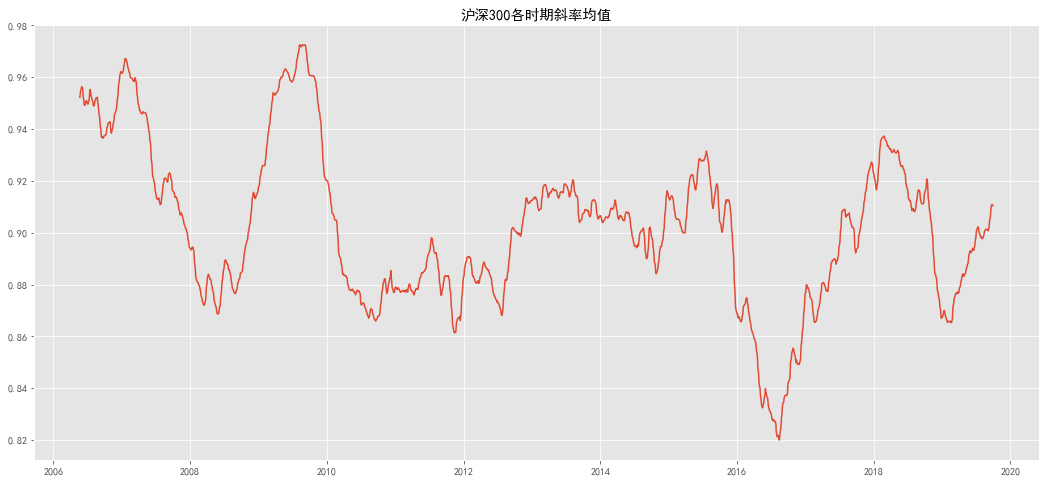

In [12]:
# 各期斜率情况
plt.figure(figsize=(18,8))
plt.title('沪深300各时期斜率均值')
plt.plot(RSRS_df['RSRS'].rolling(250).mean())

因此使用 RSRS标准分指标能更加灵活地适应近期的整体市场基本状态。利用RSRS标准分而不是斜率值作为指标值，我们实际上增加了策略的自度参数从1个增至3个，多出的参数分别为计算标准分所用的周期M， 以及开平仓阈值S。 则RSRS 标准分交易策略为： 

1. 根据斜率计算标准分（参数N=18,M=600）。 
2. 如果标准分大于 S（参数S=0.7），则买入持有。
3. 如果标准分小于-S，则卖出平仓。

ps:<font color=Darkred>研报给出的S=0.7,这个值是怎么来的？</font>

In [13]:
# 构造标准分RSRS

def Cal_RSRS_Zscore(datas,N, M):
    df=Cal_RSRS(datas,N)
    df['RSRS_temp'] = df['RSRS'].fillna(0)
    # df = Cal_RSRS(df, N)  # 计算基础斜率
    ZSCORE = (df['RSRS_temp']-df['RSRS_temp'].rolling(M).mean()
              )/df['RSRS_temp'].rolling(M).std()
    df['RSRS_Z'] = ZSCORE
    df = df.drop(columns='RSRS_temp')
    return df


# 计算标准分斜率
RSRS_Z = Cal_RSRS_Zscore(RSRS_df, 18,600)

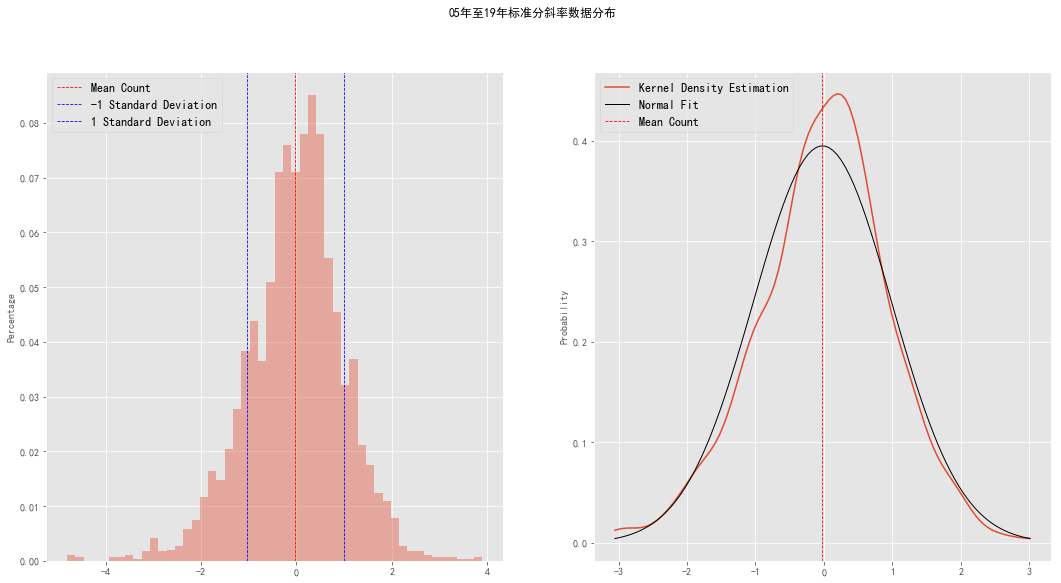

In [14]:
# 查看标准分斜率分布
stat_depict_plot(RSRS_Z,'RSRS_Z','05年至19年标准分斜率数据分布')

In [15]:
# 查看低阶距分布
print('05年至19年历史RSRS标准分斜率低阶距统计')
stat_depict(RSRS_Z,'RSRS_Z')

05年至19年历史RSRS标准分斜率低阶距统计

        平均数 : -0.0219
        中位数 : 0.0470
        标准差 : 1.0101
        偏度   : -0.3748
        峰度   : 1.2771
        1 Standard Deviation : 0.9882
        -1 Standard Deviation : -1.0320
        


## <font color=DarkMagenta>RSRS指标择时效果</font>

策略应用在 2007年9月到 2019 年 9 月的沪深 300 指数数据上： 斜率策略交易34次，在不计成本的情况下19年总收229.01%，平均年化 10.72%，夏普比率 0.69，最大回撤41.98%。标准分策略交易48次，在不计成本的情况下19年总收益401.52%，平均年化14.78%，夏普比率0.88，最大回撤46.16%。

In [122]:
# 择时指标回测
def RSRS_Strategy(datas, N, M):
    df=datas.copy()
    RSRS_Z = Cal_RSRS_Zscore(df,N, M)  # 计算标准分指标
    
    # 需要扣除前期计算的600日
    RSRS_Z=RSRS_Z[max(N,M):]
    
    print('回测起始日：',min(RSRS_Z.index))
    # 基础信号回测
    basic_singal = []
    for row in range(len(RSRS_Z)):

        if RSRS_Z['RSRS'][row] > 1.02:
            basic_singal.append(1)
        else:
            if row != 0:
                if basic_singal[-1] and RSRS_Z['RSRS'][row] > 0.78:
                    basic_singal.append(1)
                else:
                    basic_singal.append(0)
            else:
                basic_singal.append(0)

    # 储存基础信号
    RSRS_Z['basic_singal'] = basic_singal

    # 计算标准信号，S=0.7 研报给出的 我都不知到怎么来的
    z_singal = []
    S = 0.7
    for row in range(len(RSRS_Z)):

        if RSRS_Z['RSRS_Z'][row] > S:
            z_singal.append(1)

        else:
            if row != 0:
                if z_singal[-1] and RSRS_Z['RSRS_Z'][row] > -S:
                    z_singal.append(1)
                else:
                    z_singal.append(0)
            else:
                z_singal.append(0)

    # 储存标准分信号
    RSRS_Z['z_singal'] = z_singal
    
    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()

    # 斜率净值
    BASIC_CUM = (1+RSRS_Z['basic_singal']*RSRS_Z['ret']).cumprod()
    # 标准分净值
    Z_CUM = (1+RSRS_Z['z_singal']*RSRS_Z['ret']).cumprod()
    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()

    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(BASIC_CUM, label='斜率指标策略')
    ax1.plot(Z_CUM, label='标准分指标策略')
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS指标策略净值曲线')
    plt.show()
    
    display(HTML(summary(RSRS_Z).to_html()))
    
    
# 风险报告
def summary(df,singal_name=['basic_singal', 'z_singal']):

    summary_dic = {}
    index_name = '年华收益率,累计收益率,夏普比率,最大回撤,持仓总天数,交易次数,平均持仓天数,获利天数, \
    亏损天数,胜率(按天),平均盈利率(按天),平均亏损率(按天),平均盈亏比(按天),盈利次数,亏损次数, \
    单次最大盈利,单次最大亏损,胜率(按此),平均盈利率(按次),平均亏损率(按次),平均盈亏比(按次)'.split(
        ',')
    
    col_dic=dict(zip(['RSRS_singal','RSRS_Z_singal','RSRS_Revise_singal','RSRS_Positive_singal']
                    ,['斜率指标策略','标准分指标策略','修正标准分策略','右偏标准分策略']))
    
    
    # 判断是否是默认的singal_name
    if singal_name[0] in col_dic:
        col_name=[col_dic[x] for x in singal_name]
    else:
        col_name = '斜率指标策略,标准分指标策略'.split(',')
        
    def format_x(x):
        return '{:.2%}'.format(x)

    for singal in singal_name:
        
        RET = df['ret']*df[singal]
        CUM_RET = (1+RET).cumprod()
        
        # 计算年华收益率
        annual_ret = CUM_RET[-1]**(250/len(RET)) - 1
        
        # 计算累计收益率
        cum_ret_rate = CUM_RET[-1] - 1

        # 最大回撤
        max_nv = np.maximum.accumulate(np.nan_to_num(CUM_RET))
        mdd = -np.min(CUM_RET / max_nv - 1)
        
        # 夏普
        sharpe_ratio = np.mean(RET)/np.nanstd(RET, ddof=1)*np.sqrt(250)
        
        # 标记买入卖出时点
        mark = df[singal]
        pre_mark = np.nan_to_num(df[singal].shift(-1))
        # 买入时点
        trade = (mark == 1) & (pre_mark < mark)

        # 交易次数
        trade_count = np.nansum(trade)

        # 持仓总天数
        total = np.sum(mark)
        # 平均持仓天数
        mean_hold = total/trade_count
        # 获利天数
        win = np.sum(np.where(RET > 0, 1, 0))
        # 亏损天数
        lose = np.sum(np.where(RET < 0, 1, 0))
        # 胜率
        win_ratio = win/total
        # 平均盈利率（天）
        mean_win_ratio = np.sum(np.where(RET > 0, RET, 0))/win
        # 平均亏损率（天）
        mean_lose_ratio = np.sum(np.where(RET < 0, RET, 0))/lose
        # 盈亏比(天)
        win_lose = win/lose

        # 盈利次数
        temp_df = df.copy()
        diff = temp_df[singal] != temp_df[singal].shift(1)
        temp_df['mark'] = diff.cumsum()
        # 每次开仓的收益率情况
        temp_df = temp_df.query(singal+'==1').groupby('mark')['ret'].sum()
    
        # 盈利次数
        win_count = np.sum(np.where(temp_df > 0, 1, 0))
        # 亏损次数
        lose_count = np.sum(np.where(temp_df < 0, 1, 0))
        # 单次最大盈利
        max_win = np.max(temp_df)
        # 单次最大亏损
        max_lose = np.min(temp_df)
        # 胜率
        win_rat = win_count/len(temp_df)
        # 平均盈利率（次）
        mean_win = np.sum(np.where(temp_df > 0, temp_df, 0))/len(temp_df)
        # 平均亏损率（天）
        mean_lose = np.sum(np.where(temp_df<0, temp_df, 0))/len(temp_df)
        # 盈亏比(次)
        mean_wine_lose = win_count/lose_count

        summary_dic[singal] = [format_x(annual_ret), format_x(cum_ret_rate),sharpe_ratio,format_x(
            mdd), total, trade_count, mean_hold, win, lose, format_x(win_ratio), format_x(mean_win_ratio),
            format_x(mean_lose_ratio), win_lose, win_count, lose_count, format_x(
                max_win), format_x(max_lose),
            format_x(win_rat), format_x(mean_win), format_x(mean_lose), mean_wine_lose]
        
    summary_df=pd.DataFrame(summary_dic,index=index_name)
    summary_df.columns=col_name
    return summary_df

回测起始日： 2007-09-25 00:00:00


<Figure size 432x288 with 0 Axes>

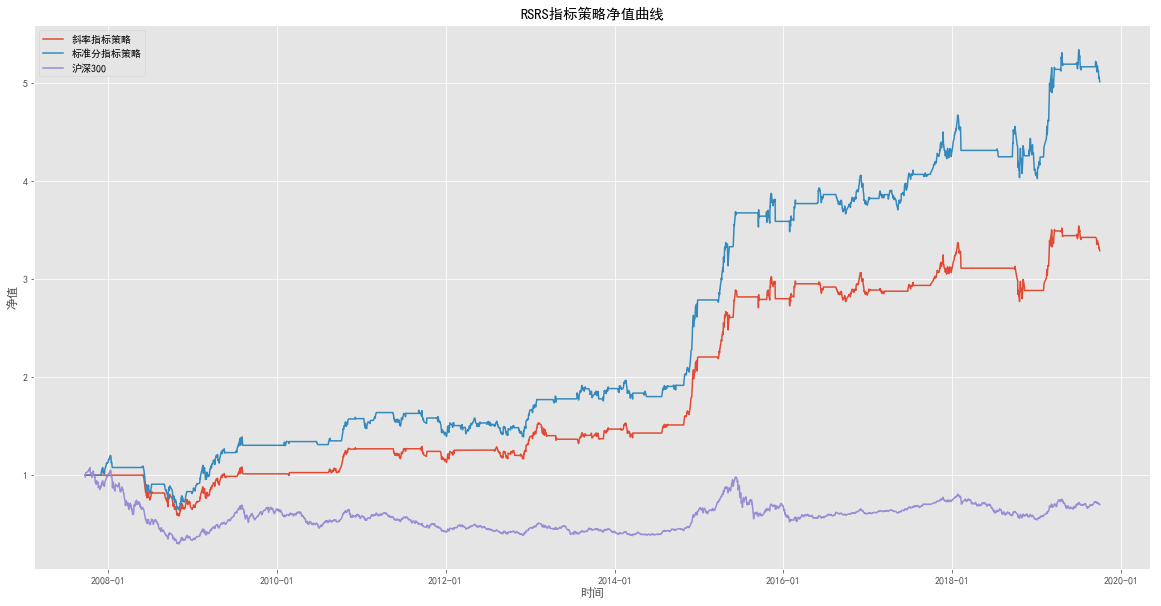

,斜率指标策略,标准分指标策略
年华收益率,10.72%,14.78%
累计收益率,229.01%,401.52%
夏普比率,0.692513,0.878087
最大回撤,41.98%,46.16%
持仓总天数,1099,1358
交易次数,34,48
平均持仓天数,32.3235,28.2917
获利天数,589,728
亏损天数,510,630
胜率(按天),53.59%,53.61%


In [77]:
# 无双边手续费情况
RSRS_Strategy(df,18,600)

回测起始日： 2007-09-25 00:00:00
不含费净值：5.02,含费净值：4.15


<Figure size 432x288 with 0 Axes>

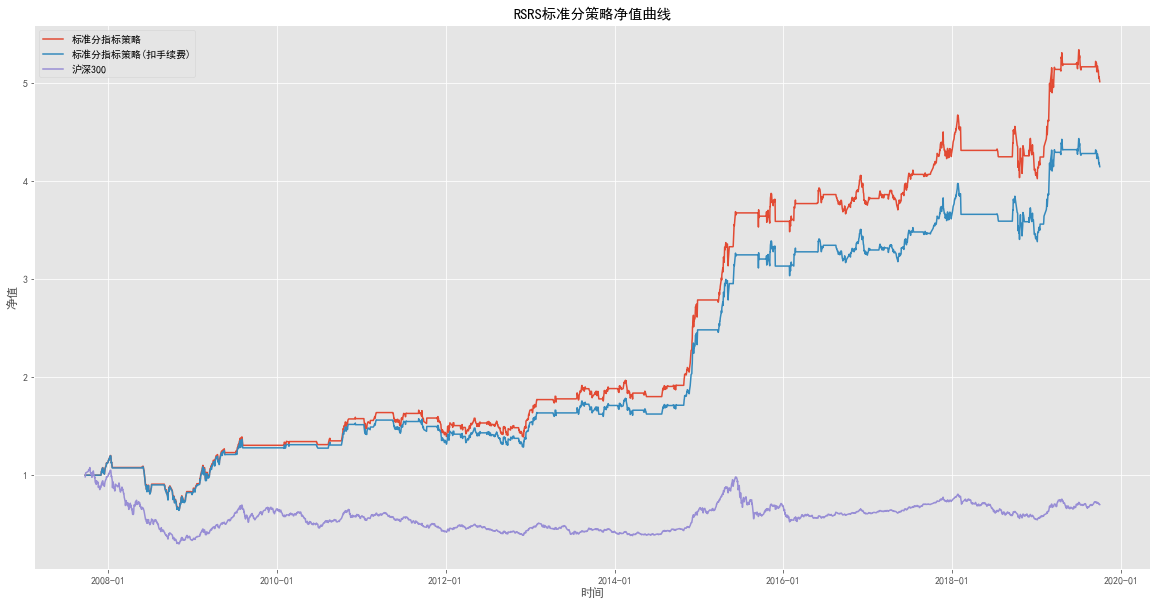

In [18]:
# 含费率
# 择时指标回测
def RSRS_Strategy_FEE(datas, N, M):
    df=datas.copy()
    RSRS_Z = Cal_RSRS_Zscore(df,N, M)  # 计算标准分指标
    
    # 需要扣除前期计算的600日
    RSRS_Z=RSRS_Z[max(N,M):]
    
    print('回测起始日：',min(RSRS_Z.index))

    # 计算标准信号，S=0.7 研报给出的 我都不知到怎么来的
    z_singal = []
    S = 0.7
    for row in range(len(RSRS_Z)):

        if RSRS_Z['RSRS_Z'][row] > S:
            z_singal.append(1)

        else:
            if row != 0:
                if z_singal[-1] and RSRS_Z['RSRS_Z'][row] > -S:
                    z_singal.append(1)
                else:
                    z_singal.append(0)
            else:
                z_singal.append(0)

    # 储存标准分信号
    RSRS_Z['z_singal'] = z_singal
    
    RSRS_Z=cal_fee(RSRS_Z,'z_singal')
    
    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()
    
    # 标准分净值 不含费
    Z_CUM = (1+RSRS_Z['z_singal']*RSRS_Z['ret']).cumprod()
    # 标准分净值 含费
    Z_CUM_fee = (1+RSRS_Z['z_singal']*RSRS_Z['ret']-RSRS_Z['cost']).cumprod()
    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()
    print('不含费净值：%2.2f,含费净值：%2.2f'%(Z_CUM[-1],Z_CUM_fee[-1]))
    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(Z_CUM, label='标准分指标策略')
    ax1.plot(Z_CUM_fee, label='标准分指标策略(扣手续费)')
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS标准分策略净值曲线')
    plt.show()

RSRS_Strategy_FEE(df,18,600)

从统计数据来看，标准分指标无论从**收益率、夏普比率**还是**最大回撤**上 都证实了我们认为<font color=CornFlowerBlue>**标准分指标**</font>在择时效果上<font color=Darkred>**优于**</font><font color=CornFlowerBlue>**斜率指标**</font>的观点。同时我们可以观察到无论是斜率指标还是标准分指标都在09年至14年的震荡区间净值较稳定增长，这正是RSRS 指标优秀左侧预测能力的体现。

我们统计成本对RSRS 斜率策略的影响以及策略对唯一参数（计算斜率使用的数据个数N）的敏感性。 

由于交易次数较少，持仓时间较长，交易成本对策略的冲击并不大，无成本净值5.01，**双边成本 0.6%时净值4.15**。而参数的选取对策略会有些微影响，可以观察到净值在参数为 20 时有一个明显下跌。可能的原因是 20 是许多技术指标（如均线计算）的默认常用参数，因此当大量交易者按照以 20 这个周期计算的技术指标进行交易，就会影响到 20 这个周期的最高价最、低价数据信息分布。但总体上看净值相对对于参数还是一个开口向下的抛物线形状。

## <font color=DarkMagenta>RSRS标准分指标优化</font>

从标准分策略中，我们发现巨大的回撤发生在2008年大熊市中期，一种猜测是策略将其误判为下跌见底，从而尝试抄底买入。由于在大熊市中， 每日跌幅十分巨大，这样的错误信号即使策略在几天后发现依旧在下跌趋势而平仓，往往也已经造成巨大损失。

我们希望通过对修正指标本身或融合其它量价信息来使得策略得到优化。

我们使用线性拟合，并用斜率来量化支撑阻力相对强度。这样量化的方式使得所得斜率是否能够较有效地表达支撑阻力相对强度很大程度上受拟合本身效果的影响。在线性回归中，R平方值（决定系数）可以理解成线性拟合效果的程度，取值在[0,1]区间，1表示完全拟合。为了削弱拟合效果对策略的影响，我们通过<font color=Darkred>**将标准分值与决定系数相乘得到修正标准分**</font>。以此降低绝对值很大，但实际拟合效果很差的标准分对策略的影响。由于这种修正方式是由决定系数的大小直接决定对于拟合效果的惩罚力度，因此并不适合直接用于斜率指标。若直接与斜率相乘，实质上更多效果只是拉大斜率的大小差距，而并没有对拟合效果差的惩罚效果。

In [19]:
# 计算修正RSRS
def Cal_RSRS_Revise(datas, N, M):
    df = datas.copy()
    df = Cal_RSRS_Zscore(df, N, M)
    # 获取R方
    temp = [np.nan]*N
    for row in range(len(df)-N):
        x = sm.add_constant(df['low'][row:row+N])
        y = df['high'][row:row+N]
        r = sm.OLS(y, x).fit().rsquared
        temp.append(r)

    df['rsquared'] = temp
    df['RSRS_Revise'] = df['rsquared']*df['RSRS_Z']
    return df


# 获取修正标准分
RSRS_Revise = Cal_RSRS_Revise(df, 18, 600)

我们在沪深300指数上运用无偏标准分指标策略并与标准分策略进行比较。除了些许变化，净值曲线形状近乎相同，没有解决在大熊市中错判开仓的问题，**修正标准分指标策略净值由标准分策略的5.02减少至3.73**， 收益反而有所减少。 

虽然基于拟合效果的指标优化结果不尽人意，但优化的方式本质上是改变了标准分分布。我们期望能通过研究标准分分布对未来市场收益的预测性
来继续优化指标本身。

回测起始日： 2007-09-25 00:00:00
不含费净值：3.73,含费净值：3.15


<Figure size 432x288 with 0 Axes>

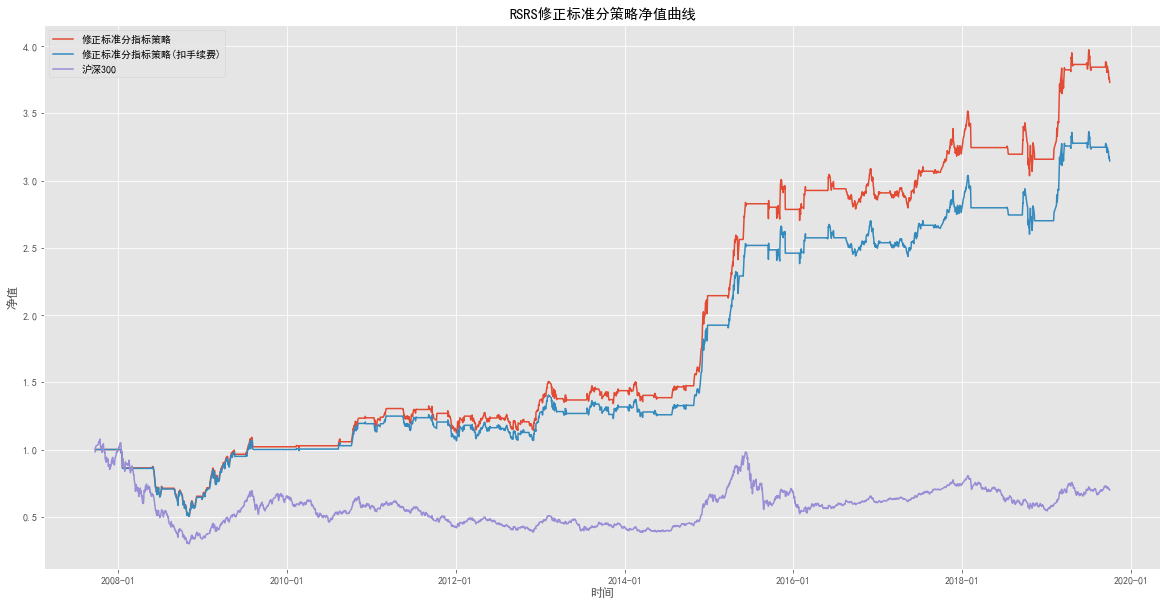

In [20]:
# 修正标准分(含费率)
# 修正标准分择时指标回测
def RSRS_Strategy_Revise(datas, N, M,pl=True):
    df=datas.copy()
    RSRS_Z = Cal_RSRS_Revise(df,N, M)  # 计算标准分指标
    
    # 需要扣除前期计算的600日
    RSRS_Z=RSRS_Z[max(N,M):]
    
    print('回测起始日：',min(RSRS_Z.index))

    # 计算标准信号，S=0.7 研报给出的 我都不知到怎么来的
    z_singal = []
    S = 0.7
    for row in range(len(RSRS_Z)):

        if RSRS_Z['RSRS_Revise'][row] > S:
            z_singal.append(1)

        else:
            if row != 0:
                if z_singal[-1] and RSRS_Z['RSRS_Revise'][row] > -S:
                    z_singal.append(1)
                else:
                    z_singal.append(0)
            else:
                z_singal.append(0)

    # 储存标准分信号
    RSRS_Z['z_singal'] = z_singal
    
    RSRS_Z=cal_fee(RSRS_Z,'z_singal')
    
    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()
    
    # 标准分净值 不含费
    Z_CUM = (1+RSRS_Z['z_singal']*RSRS_Z['ret']).cumprod()
    # 标准分净值 含费
    Z_CUM_fee = (1+RSRS_Z['z_singal']*RSRS_Z['ret']-RSRS_Z['cost']).cumprod()
    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()
    print('不含费净值：%2.2f,含费净值：%2.2f'%(Z_CUM[-1],Z_CUM_fee[-1]))
    if pl:
        # 画图
        plt.figure()
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1, 1, 1)

        ax1.plot(Z_CUM, label='修正标准分指标策略')
        ax1.plot(Z_CUM_fee, label='修正标准分指标策略(扣手续费)')
        ax1.plot(benchmark, label='沪深300')

        ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
        plt.legend(loc='best')
        plt.xlabel('时间')
        plt.ylabel('净值')
        plt.title('RSRS修正标准分策略净值曲线')
        plt.show()
    else:
        return RSRS_Z

# 修正标准分
RSRS_Strategy_Revise(df,18,600)

同时我们对标准分与修正标准分的分布进行检查（参数 600,18），可以明显看出，**修正后的标准分在偏度上有明显的向正态修正的效果。**

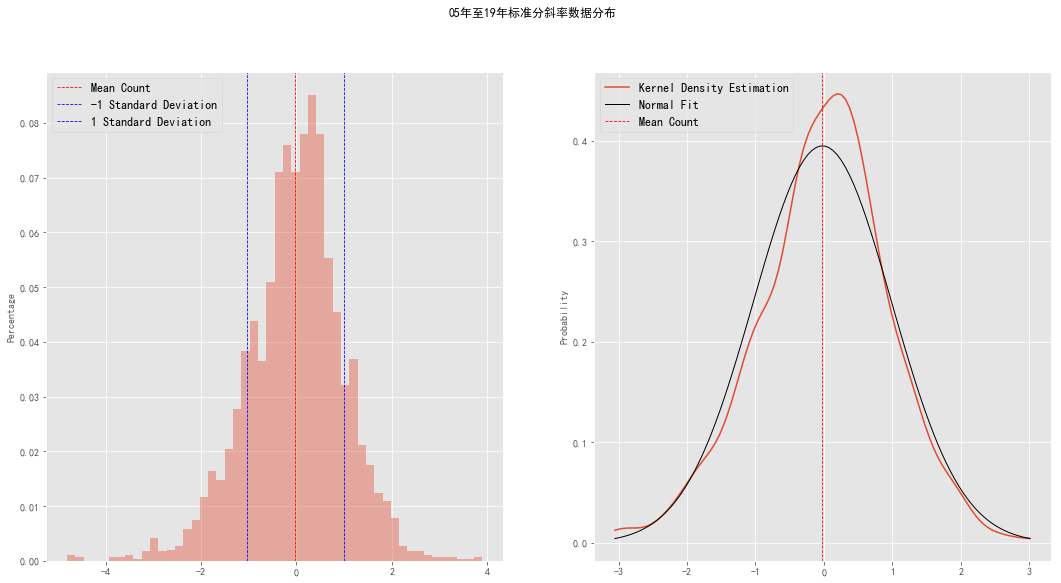

In [21]:
# 标准分斜率分布
stat_depict_plot(RSRS_Z,'RSRS_Z','05年至19年标准分斜率数据分布')

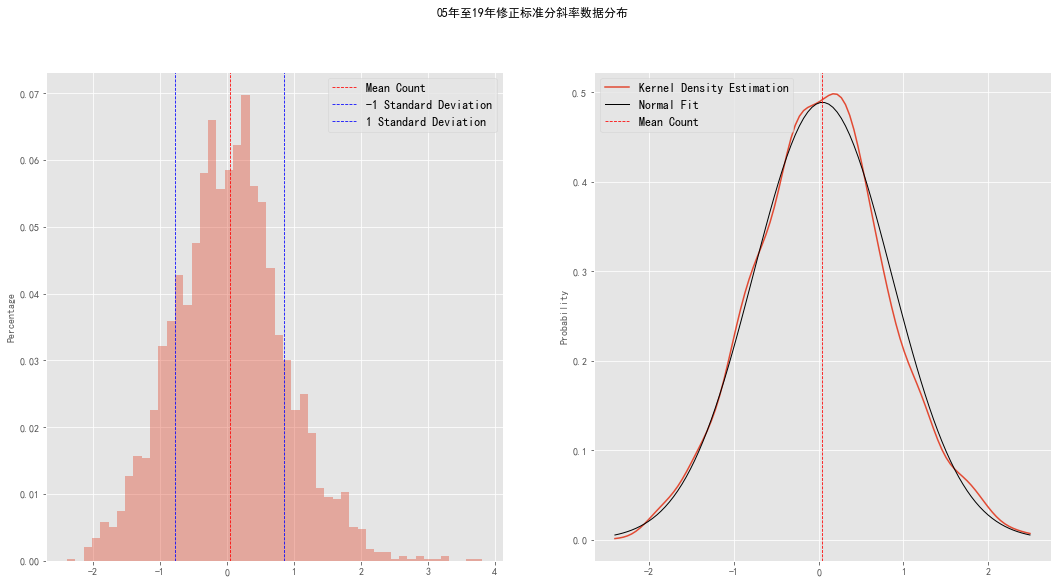

In [22]:
# 修正标准分分布
stat_depict_plot(RSRS_Revise,'RSRS_Revise','05年至19年修正标准分斜率数据分布')

In [23]:
# RSRS标准分与RSRS修正标准分分布数据比较
stat_depict_df = pd.concat([pd.Series(stat_depict(RSRS_Revise, 'RSRS_Revise', pr=False)),
                            pd.Series(stat_depict(RSRS_Z, 'RSRS_Z', pr=False))], axis=1)

stat_depict_df.columns = ['修正标准分', '标准分']

print('RSRS标准分与RSRS修正标准分分布数据比较')
display(HTML(stat_depict_df.T.to_html()))

RSRS标准分与RSRS修正标准分分布数据比较


,平均数,中位数,标准差,偏度,峰度,1 Standard Deviation,-1 Standard Deviation
修正标准分,4.3749%,4.3316%,81.6292%,24.0716%,40.2846%,86.0041%,-77.2543%
标准分,-2.1896%,4.7028%,101.0143%,-37.4796%,127.7119%,98.8247%,-103.2039%


In [24]:
# 获取因子后N日的上涨概率/收益期望
def plot_average_cumulative_return(df,factor_name,after=10,title=None,probability=True,prt=True):
    '''
    df 因子计算后的df
    factor_name df中因子的名称
    title 图标的标题
    after 之后N日
    probability True计算概率 False 计算平均收益
    '''
    RSRS=df[['close',factor_name]].copy()
    # 计算未来N日收益率
    RSRS['ret']=RSRS.close.pct_change(after).shift(-after)
    group=pd.cut(RSRS[factor_name],50)
    RSRS['group']=group
    if probability:
        # 计算上涨概率
        after_ret=RSRS.groupby('group')['ret'].apply(lambda x:np.sum(np.where(x>0,1,0))/len(x))
    else:
        after_ret=RSRS.groupby('group')['ret'].mean()
        
    if prt:
        # 画图
        plt.figure(figsize=(18,6))
        # 设置标题
        plt.title(title)
        size=len(after_ret)
        plt.bar(range(size),after_ret.values,width=0.8,alpha=0.5)
        # rotation旋转x轴标签
        plt.xticks(range(size), after_ret.index.categories.right, rotation=30)
        # 设置y轴标题
        plt.ylabel('上涨概率')
    else:
        return after_ret

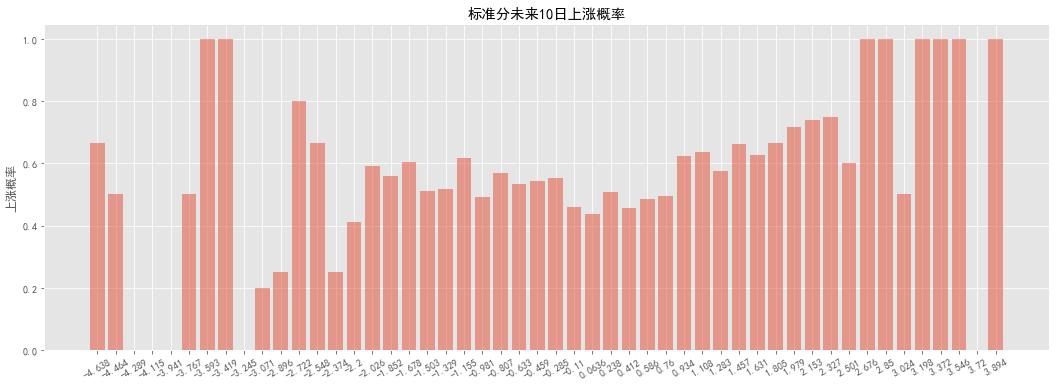

In [25]:
# 标准分未来10日上涨概率
plot_average_cumulative_return(RSRS_Z,'RSRS_Z',after=10,title='标准分未来10日上涨概率')

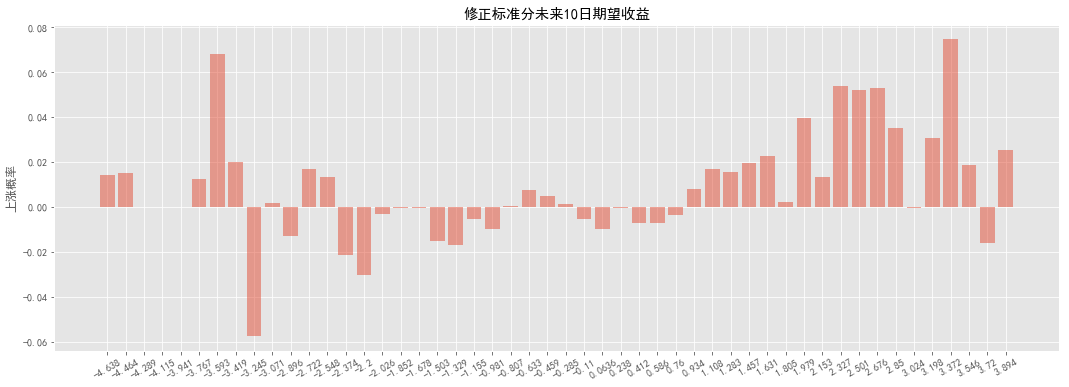

In [26]:
# 标准分未来10日期望收益
plot_average_cumulative_return(RSRS_Z,'RSRS_Z',after=10,title='修正标准分未来10日期望收益',probability=False)

In [27]:
# 标准分与相关系数
print('-'*30, '\n右侧标准分:\n')
zr_df = plot_average_cumulative_return(
    RSRS_Z, 'RSRS_Z', after=10, prt=False, probability=False)
zr_df.index = zr_df.index.categories.right
zr_df = zr_df.fillna(0)
zr_df = zr_df.reset_index()
zr_df.columns = ['factor', 'ret']
rq = zr_df.query('factor>0')

zp_df = plot_average_cumulative_return(
    RSRS_Z, 'RSRS_Z', after=10, prt=False, probability=True)
zp_df.index = zp_df.index.categories.right
zp_df = zp_df.fillna(0)
zp_df = zp_df.reset_index()
zp_df.columns = ['factor', 'ret']
pq = zp_df.query('factor>0')


print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['factor'], rq['ret'])[0][1])

print('标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(pq['factor'], pq['ret'])[0][1])


print('-'*30, '\n左侧标准分:\n')
rq = zr_df.query('factor<0')
pq = zp_df.query('factor<0')

print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['factor'], rq['ret'])[0][1])

print('标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(pq['factor'], pq['ret'])[0][1])

print('-'*30, '\n标准分整体:\n')
rq = zr_df
pq = zp_df

print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['ret'], rq['factor'])[0][1])
print('标准分与上涨概率相关系数:%.2f'
      % np.corrcoef(pq['ret'], pq['factor'])[0][1])

------------------------------ 
右侧标准分:

标准分与期望收益相关系数:0.48
标准分与未来上涨概率相关系数:0.45
------------------------------ 
左侧标准分:

标准分与期望收益相关系数:-0.24
标准分与未来上涨概率相关系数:0.24
------------------------------ 
标准分整体:

标准分与期望收益相关系数:0.38
标准分与上涨概率相关系数:0.46


In [28]:
# 废
'''
#------------------------感觉不对-------------------------
# 标准分与相关系数
corr_df=RSRS_Z.copy()
print('-'*30,'\n右侧标准分:\n')
# 计算标准分与未来10日期望收益的相关系数
## 计算未来10日收益
corr_df['ret'] = corr_df.close.pct_change(10).shift(-10)
## 标准分大于0
corr_df1 = corr_df.query('RSRS_Z>0').dropna()
# 标准分>0，与未来10日的收益率相关系数
print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(corr_df1['ret'], corr_df1['RSRS_Z'])[1][0])

# 计算未来10日上涨概率
## 计算每日收益率
corr_df_p=corr_df.copy()
corr_df_p['ret']=corr_df_p.close.pct_change()
corr_df_p['P']=corr_df_p['ret'].rolling(10).apply(lambda x:np.sum(np.where(x>0,1,0))/len(x)).shift(-10)
corr_df2 = corr_df_p.query('RSRS_Z>0').dropna()
# 标准分>0，与未来10日的上涨概率相关系数
print('标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(corr_df2['ret'], corr_df2['P'])[1][0])

print('-'*30,'\n左侧标准分:\n')

# 计算标准分与未来10日上涨概率相关系数
## 标准分大于0
corr_df3 = corr_df.query('RSRS_Z<0').dropna()
# 标准分>0，与未来10日的收益率相关系数
print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(corr_df3['ret'], corr_df3['RSRS_Z'])[1][0])

# 计算未来10日上涨概率
## 计算每日收益率
corr_df_4 = corr_df_p.query('RSRS_Z<0').dropna()
# 标准分>0，与未来10日的上涨概率相关系数
print('标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(corr_df_4['ret'], corr_df_4['P'])[1][0])

print('-'*30,'\n标准分整体:\n')
corr_df_5=corr_df.dropna()
print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(corr_df_5['ret'], corr_df_5['RSRS_Z'])[1][0])
'''

"\n#------------------------感觉不对-------------------------\n# 标准分与相关系数\ncorr_df=RSRS_Z.copy()\nprint('-'*30,'\n右侧标准分:\n')\n# 计算标准分与未来10日期望收益的相关系数\n## 计算未来10日收益\ncorr_df['ret'] = corr_df.close.pct_change(10).shift(-10)\n## 标准分大于0\ncorr_df1 = corr_df.query('RSRS_Z>0').dropna()\n# 标准分>0，与未来10日的收益率相关系数\nprint('标准分与期望收益相关系数:%.2f'\n      % np.corrcoef(corr_df1['ret'], corr_df1['RSRS_Z'])[1][0])\n\n# 计算未来10日上涨概率\n## 计算每日收益率\ncorr_df_p=corr_df.copy()\ncorr_df_p['ret']=corr_df_p.close.pct_change()\ncorr_df_p['P']=corr_df_p['ret'].rolling(10).apply(lambda x:np.sum(np.where(x>0,1,0))/len(x)).shift(-10)\ncorr_df2 = corr_df_p.query('RSRS_Z>0').dropna()\n# 标准分>0，与未来10日的上涨概率相关系数\nprint('标准分与未来上涨概率相关系数:%.2f'\n      % np.corrcoef(corr_df2['ret'], corr_df2['P'])[1][0])\n\nprint('-'*30,'\n左侧标准分:\n')\n\n# 计算标准分与未来10日上涨概率相关系数\n## 标准分大于0\ncorr_df3 = corr_df.query('RSRS_Z<0').dropna()\n# 标准分>0，与未来10日的收益率相关系数\nprint('标准分与期望收益相关系数:%.2f'\n      % np.corrcoef(corr_df3['ret'], corr_df3['RSRS_Z'])[1][0])\n\n# 计算未来1

虽然基于拟合效果的指标优化结果不尽人意，但优化的方式本质上是改变了标准分分布。<u>我们期望能通过研究标准分分布对未来市场收益的预测性来继续优化指标本身。</u>

我们通过研究标准分以及对应其后未来 10 日的市场涨跌概率及预期收益率来判断比较指标对未来市场收益的预测性。 研究标准分的值与给出相应标准分对应沪深 300 指数后 10 天的收益率的关系，从标准分平均收益及总收益分布图中可以明显看出右侧标准分（z>0 标准分大于0的部分） 与未来 10 天沪深 300 的收益率有尚可的正相关性，从上面两个图中可以得出与研报相同结论。

但在标准分与期望收益相关系数、上涨概率相关系数的计算中出现分歧：

**右侧标准分：**(z>0 标准分小于0的部分）

- <font color=Darkred>**标准分值与期望收益的相关系数研报计算数为0.45，我计算出来为0.48**</font>
- <font color=Darkred>**标准分值与上涨概率的相关系数研报计算数为0.27，我的计算数为0.45**</font>



`故研报结论为：大于0的标准分是较好的牛市预测指标。`

**左侧标准分**(z<0 标准分小于0的部分）

- <font color=Darkred>**标准分值与期望收益的相关系数研报计算数为-0.21，我计算出来为-0.24**</font>
- <font color=Darkred>**标准分值与上涨概率的相关系数研报计算数为-0.01，我的计算数为0.24**</font>

**标准分整体** 

- <font color=Darkred>**标准分值与期望收益的相关系数研报计算数为0.31，我计算出来为0.36**</font>

ps:请教一下这两个的相关系数应该如何计算？

In [29]:
# 修正标准分与相关系数
print('-'*30, '\n右侧修正标准分:\n')
zr_df = plot_average_cumulative_return(
    RSRS_Revise, 'RSRS_Revise', after=10, prt=False, probability=False)
zr_df.index = zr_df.index.categories.right
zr_df = zr_df.fillna(0)
zr_df = zr_df.reset_index()
zr_df.columns = ['factor', 'ret']
rq = zr_df.query('factor>0')

zp_df = plot_average_cumulative_return(
    RSRS_Revise, 'RSRS_Revise', after=10, prt=False, probability=True)
zp_df.index = zp_df.index.categories.right
zp_df = zp_df.fillna(0)
zp_df = zp_df.reset_index()
zp_df.columns = ['factor', 'ret']
pq = zp_df.query('factor>0')


print('修正标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['factor'], rq['ret'])[0][1])

print('修正标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(pq['factor'], pq['ret'])[0][1])


print('-'*30, '\n左侧标准分:\n')
rq = zr_df.query('factor<0')
pq = zp_df.query('factor<0')

print('修正修正标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['factor'], rq['ret'])[0][1])

print('修正标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(pq['factor'], pq['ret'])[0][1])

print('-'*30, '\n修正标准分整体:\n')
rq = zr_df
pq = zp_df

print('修正标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['ret'], rq['factor'])[0][1])
print('修正标准分与上涨概率相关系数:%.2f'
      % np.corrcoef(pq['ret'], pq['factor'])[0][1])

------------------------------ 
右侧修正标准分:

修正标准分与期望收益相关系数:0.45
修正标准分与未来上涨概率相关系数:0.25
------------------------------ 
左侧标准分:

修正修正标准分与期望收益相关系数:0.17
修正标准分与未来上涨概率相关系数:0.27
------------------------------ 
修正标准分整体:

修正标准分与期望收益相关系数:0.60
修正标准分与上涨概率相关系数:0.38


In [30]:
# 信号与相关系数
'''
corr_df=RSRS_Revise.copy()
print('-'*30,'\n右侧标准分:\n')
# 计算标准分与未来10日期望收益的相关系数
## 计算未来10日收益
corr_df['ret'] = corr_df.close.pct_change(10).shift(-10)
## 标准分大于0
corr_df1 = corr_df.query('RSRS_Revise>0').dropna()
# 标准分>0，与未来10日的收益率相关系数
print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(corr_df1['ret'], corr_df1['RSRS_Revise'])[1][0])

# 计算未来10日上涨概率
## 计算每日收益率
corr_df_p=corr_df.copy()
corr_df_p['ret']=corr_df_p.close.pct_change()
corr_df_p['P']=corr_df_p['ret'].rolling(10).apply(lambda x:np.sum(np.where(x>0,1,0))/len(x)).shift(-10)
corr_df2 = corr_df_p.query('RSRS_Revise>0').dropna()
# 标准分>0，与未来10日的上涨概率相关系数
print('标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(corr_df2['ret'], corr_df2['P'])[1][0])

print('-'*30,'\n左侧标准分:\n')

# 计算标准分与未来10日上涨概率相关系数
## 标准分大于0
corr_df3 = corr_df.query('RSRS_Revise<0').dropna()
# 标准分>0，与未来10日的收益率相关系数
print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(corr_df3['ret'], corr_df3['RSRS_Revise'])[1][0])

# 计算未来10日上涨概率
## 计算每日收益率
corr_df_4 = corr_df_p.query('RSRS_Revise<0').dropna()
# 标准分>0，与未来10日的上涨概率相关系数
print('标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(corr_df_4['ret'], corr_df_4['P'])[1][0])

print('-'*30,'\n标准分整体:\n')
corr_df_5=corr_df.dropna()
print('标准分与期望收益相关系数:%.2f'
      % np.corrcoef(corr_df_5['ret'], corr_df_5['RSRS_Revise'])[1][0])
'''

"\ncorr_df=RSRS_Revise.copy()\nprint('-'*30,'\n右侧标准分:\n')\n# 计算标准分与未来10日期望收益的相关系数\n## 计算未来10日收益\ncorr_df['ret'] = corr_df.close.pct_change(10).shift(-10)\n## 标准分大于0\ncorr_df1 = corr_df.query('RSRS_Revise>0').dropna()\n# 标准分>0，与未来10日的收益率相关系数\nprint('标准分与期望收益相关系数:%.2f'\n      % np.corrcoef(corr_df1['ret'], corr_df1['RSRS_Revise'])[1][0])\n\n# 计算未来10日上涨概率\n## 计算每日收益率\ncorr_df_p=corr_df.copy()\ncorr_df_p['ret']=corr_df_p.close.pct_change()\ncorr_df_p['P']=corr_df_p['ret'].rolling(10).apply(lambda x:np.sum(np.where(x>0,1,0))/len(x)).shift(-10)\ncorr_df2 = corr_df_p.query('RSRS_Revise>0').dropna()\n# 标准分>0，与未来10日的上涨概率相关系数\nprint('标准分与未来上涨概率相关系数:%.2f'\n      % np.corrcoef(corr_df2['ret'], corr_df2['P'])[1][0])\n\nprint('-'*30,'\n左侧标准分:\n')\n\n# 计算标准分与未来10日上涨概率相关系数\n## 标准分大于0\ncorr_df3 = corr_df.query('RSRS_Revise<0').dropna()\n# 标准分>0，与未来10日的收益率相关系数\nprint('标准分与期望收益相关系数:%.2f'\n      % np.corrcoef(corr_df3['ret'], corr_df3['RSRS_Revise'])[1][0])\n\n# 计算未来10日上涨概率\n## 计算每日收益率\ncorr_df_4 = corr_d

之前我们考虑过线性拟合效果对于指标预测效果的影响，并利用决定系数的大小来对标准分进行修正。继续研究修正标准分的值与给出相应标准分后沪深 300 指数 10 天的收益率的关系，从修正标准分未来市场预期收益及上涨概率分布图中，可以感受到修正标准分对于其左侧预测性有所提升。

**右侧修正标准分：**(z>0 标准分小于0的部分）

- <font color=Darkred>**标准分值与期望收益的相关系数研报计算数为0.53，我计算出来为0.45**</font>
- <font color=Darkred>**标准分值与上涨概率的相关系数研报计算数为0.52，我的计算数为0.25**</font>



`故研报结论为：大于0的标准分是较好的牛市预测指标。`

**左侧侧修正标准分**(z<0 标准分小于0的部分）

- <font color=Darkred>**标准分值与期望收益的相关系数研报计算数为0.50，我计算出来为0.17**</font>
- <font color=Darkred>**标准分值与上涨概率的相关系数研报计算数为0.57，我的计算数为0.27**</font>

**修正标准分整体** 

- <font color=Darkred>**标准分值与期望收益的相关系数研报计算数为0.68，我计算出来为0.60**</font>


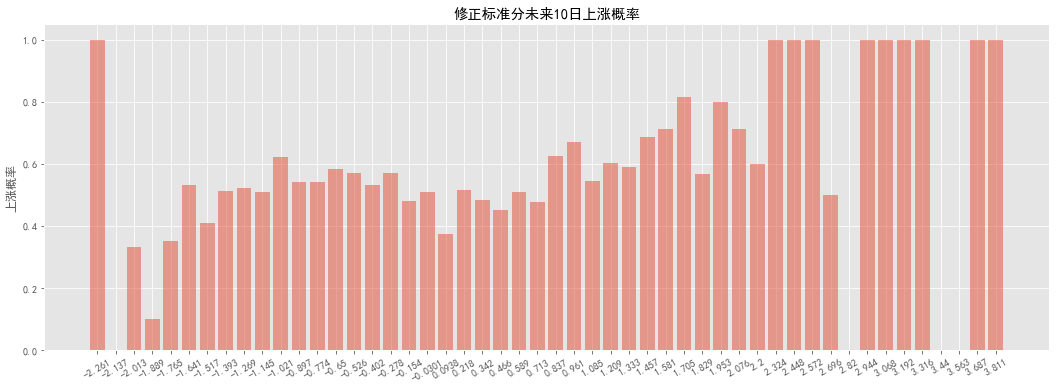

In [31]:
# 修正标准分未来10日上涨概率
plot_average_cumulative_return(RSRS_Revise,'RSRS_Revise',after=10,title='修正标准分未来10日上涨概率')

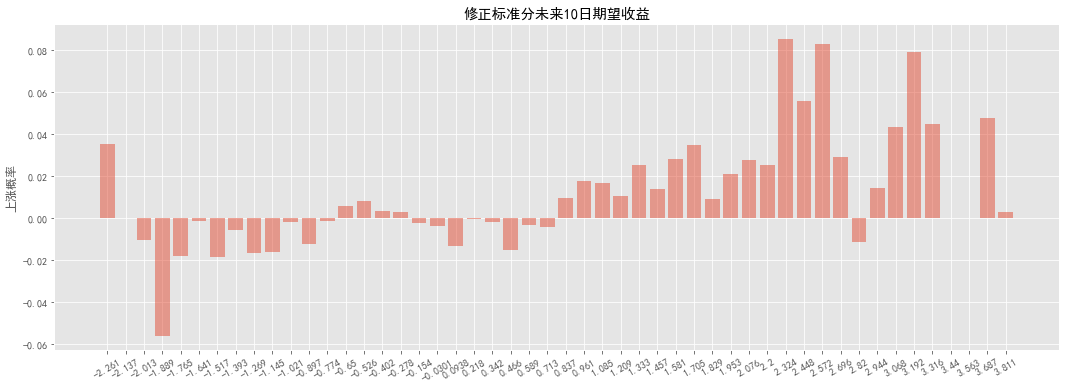

In [32]:
# 修正标准分未来10日期望收益
plot_average_cumulative_return(RSRS_Revise,'RSRS_Revise',after=10,title='修正标准分未来10日期望收益',probability=False)

回测起始日： 2007-09-25 00:00:00


<Figure size 432x288 with 0 Axes>

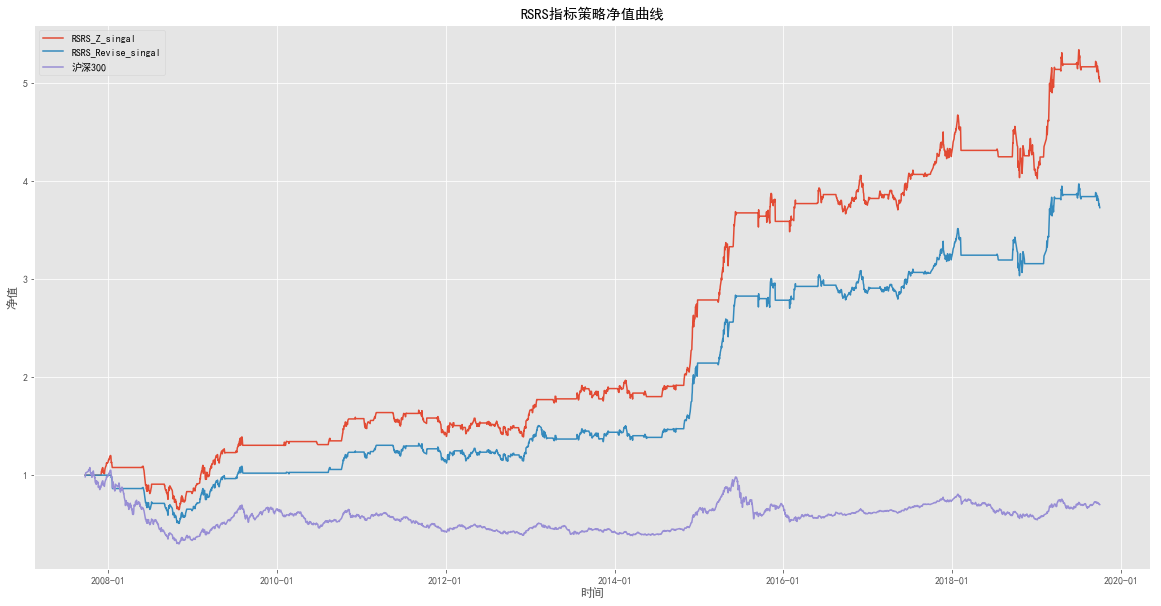

,标准分指标策略,修正标准分策略
年华收益率,14.78%,11.91%
累计收益率,401.52%,272.97%
夏普比率,0.878087,0.732093
最大回撤,46.16%,49.28%
持仓总天数,1358,1331
交易次数,48,43
平均持仓天数,28.2917,30.9535
获利天数,728,709
亏损天数,630,622
胜率(按天),53.61%,53.27%


In [88]:
# 比较修正标准分与标准分策略
def Compare_RSRS_Strategy(datas, N, M):
    df = datas.copy()

    RSRS_Z = Cal_RSRS_Revise(df, N, M)  # 计算标准分指标
    
    singal_name=['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise'.split(',')]
    # 需要扣除前期计算的600日
    RSRS_Z = RSRS_Z[max(N, M):]
    
    print('回测起始日：', min(RSRS_Z.index))
    # 获取标准分信号
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Z', 0.7, -0.7)
    # 获取修正标准分
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Revise', 0.7, -0.7)
    
    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()
    
    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    
    # 斜率净值
    for n in singal_name:
        CUM=(1+RSRS_Z[n]*RSRS_Z['ret']).cumprod()
        ax1.plot(CUM,label=n)

    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()
    
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS指标策略净值曲线')
    plt.show()
    
    display(HTML(summary(RSRS_Z,singal_name).to_html()))

# 标准信号
def get_singal(datas,singal_name,upper,lower):

    # 储存信号
    basic_singal = []
    for row in range(len(datas)):
        
        if datas[singal_name][row] > upper:
            basic_singal.append(1)
        else:
            if row != 0:
                if basic_singal[-1] and datas[singal_name][row] > lower:
                    basic_singal.append(1)
                else:
                    basic_singal.append(0)
            else:
                basic_singal.append(0)
    datas[singal_name+'_singal'] = basic_singal
    return datas

Compare_RSRS_Strategy(df,18,600)

然而为何修正标准分的预测性比标准分强，但策略净值却反而低于标准分策略？其实不难看出，修正标准分在预测性上的改善绝大部分是改善了标准分值域左侧的预测性，而右侧与标准分相差不大；而在**只做多策略中，左侧预测性的改善对于择时策略并没有很大帮助**，因而修正标准分与标准分策略的净值曲线相差不大。

对标准分进行拟合效果的修正使得指标与沪深 300 未来 10 日收益率的整体相关性得以改善。观察指标值域的改变，一个大胆的想法是，是否右侧 数据值域越广，其对未来收益率的预测越好？是否左侧数据值域越窄越好？ 能否通过改变标准分的分布来达到改善整体指标预测性的目的？ 

我们尝试验证这个想法。考虑到斜率值本身几乎一定是正值的特性，我们<font color=DarkMagenta>**将修正标准分与斜率值相乘**</font>能够达到<u>**使原有分布右偏**</u>的效果。称新的指标为<font color=Darkred>**右偏标准分**</font>。右偏标准分左侧与沪深 300 未来 10 日预期收益的相关系数增至 0.87，右侧相关系数变为 0.56，整体相关系数升至 0.75。左侧与上涨 概率的相关系数增至 0.8，右侧上涨概率相关系数变为 0.42，整体相关系数升至 0.66。指标预测性小幅增强。

In [33]:
# 计算右偏标准分
def Cal_RSRS_Positive(datas,N,M):
    df=Cal_RSRS_Revise(datas,N,M)
    df['RSRS_Positive']=df['RSRS_Revise']*df['RSRS']
    return df

RSRS_Positive=Cal_RSRS_Positive(df,18,600)

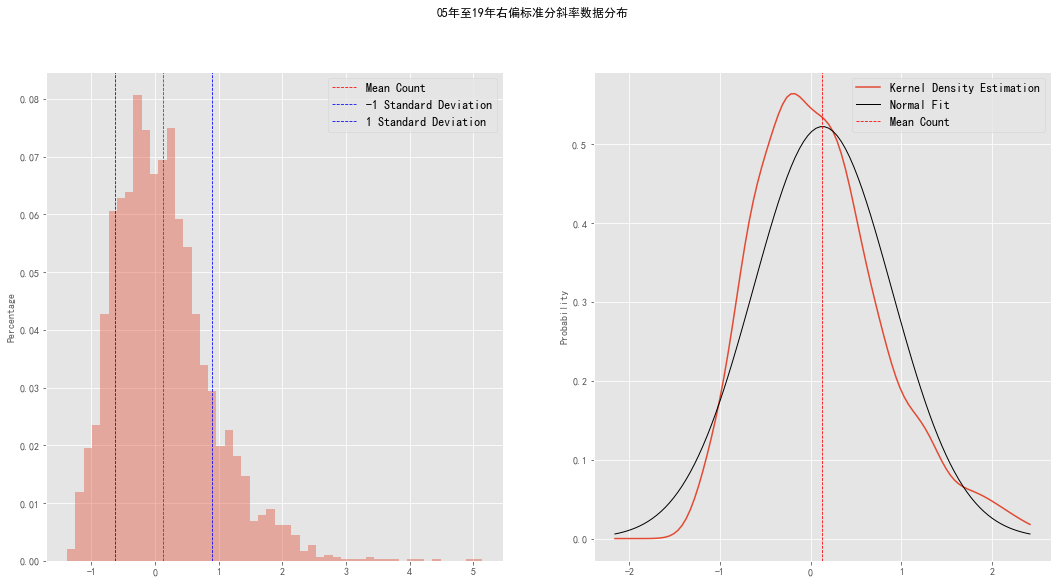

In [34]:
stat_depict_plot(RSRS_Positive,'RSRS_Positive','05年至19年右偏标准分斜率数据分布')

In [35]:
print('05年至19年历史RSRS右偏标准分斜率低阶距统计')
stat_depict(RSRS_Positive,'RSRS_Positive')

05年至19年历史RSRS右偏标准分斜率低阶距统计

        平均数 : 0.1309
        中位数 : 0.0394
        标准差 : 0.7637
        偏度   : 1.1068
        峰度   : 2.6516
        1 Standard Deviation : 0.8946
        -1 Standard Deviation : -0.6329
        


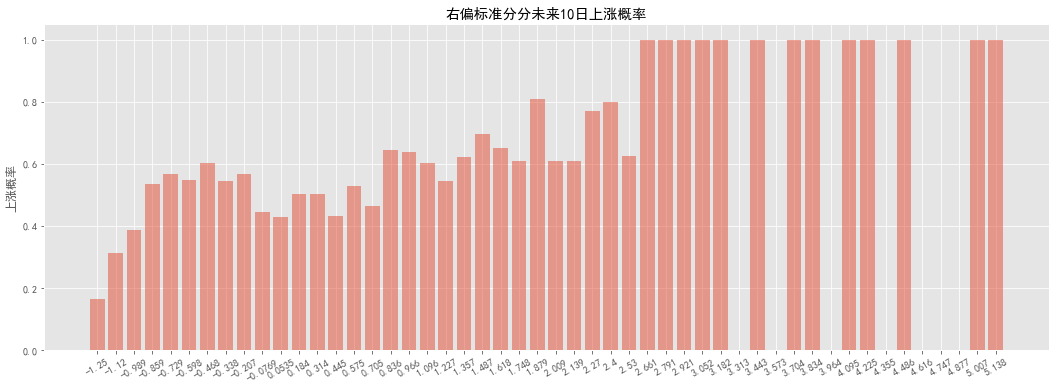

In [36]:
# 右偏标准分未来10日上涨概率
plot_average_cumulative_return(
    RSRS_Positive, 'RSRS_Positive', after=10, title='右偏标准分分未来10日上涨概率')

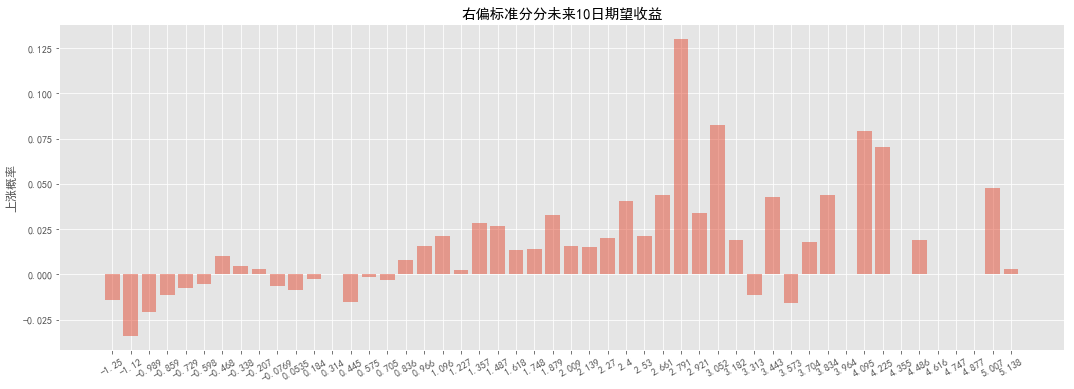

In [37]:
# 右偏标准分未来10日期望收益
plot_average_cumulative_return(
    RSRS_Positive, 'RSRS_Positive', after=10, title='右偏标准分分未来10日期望收益', probability=False)

In [38]:
# 右偏标准分与相关系数
print('-'*30, '\n右侧修正标准分:\n')
zr_df = plot_average_cumulative_return(
    RSRS_Positive, 'RSRS_Positive', after=10, prt=False, probability=False)
zr_df.index = zr_df.index.categories.right
zr_df = zr_df.fillna(0)
zr_df = zr_df.reset_index()
zr_df.columns = ['factor', 'ret']
rq = zr_df.query('factor>0')

zp_df = plot_average_cumulative_return(
    RSRS_Positive, 'RSRS_Positive', after=10, prt=False, probability=True)
zp_df.index = zp_df.index.categories.right
zp_df = zp_df.fillna(0)
zp_df = zp_df.reset_index()
zp_df.columns = ['factor', 'ret']
pq = zp_df.query('factor>0')


print('修正标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['factor'], rq['ret'])[0][1])

print('修正标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(pq['factor'], pq['ret'])[0][1])


print('-'*30, '\n左侧标准分:\n')
rq = zr_df.query('factor<0')
pq = zp_df.query('factor<0')

print('修正修正标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['factor'], rq['ret'])[0][1])

print('修正标准分与未来上涨概率相关系数:%.2f'
      % np.corrcoef(pq['factor'], pq['ret'])[0][1])

print('-'*30, '\n修正标准分整体:\n')
rq = zr_df
pq = zp_df

print('修正标准分与期望收益相关系数:%.2f'
      % np.corrcoef(rq['ret'], rq['factor'])[0][1])
print('修正标准分与上涨概率相关系数:%.2f'
      % np.corrcoef(pq['ret'], pq['factor'])[0][1])

------------------------------ 
右侧修正标准分:

修正标准分与期望收益相关系数:0.24
修正标准分与未来上涨概率相关系数:0.01
------------------------------ 
左侧标准分:

修正修正标准分与期望收益相关系数:0.74
修正标准分与未来上涨概率相关系数:0.69
------------------------------ 
修正标准分整体:

修正标准分与期望收益相关系数:0.44
修正标准分与上涨概率相关系数:0.16


我们尝试在右偏标准分指标上应用阈值交易策略，参数选取较标准分策略有所改变，N取 16，M取 300，阈值不变。 

**右偏标准分指标交易策略**： 
1. 计算右偏标准分（N=16,M=300）。 
2. 如果右偏标准分大于 S（S=0.7），则买入持有。 
3. 如果右偏标准分小于-S，则卖出平仓。 

策略应用在沪深 300 指数数据上，右偏标准分策略交易 39 次，在不计成本的情况下 12 年总收益 1573.60%，平均年化 25.82%，夏普比率 1.20， 最大回撤 -50.49%。同期沪深 300 指数总收益 350.94%。 相比标准分指标策略，右偏标准分指标策略在收益率上有小幅提高。这
与我们研究右偏标准分预测性最强的结论相吻合。然而为何修正标准分的预 测性比标准分强，但策略净值却反而低于标准分策略？其实不难看出，修正 标准分在预测性上的改善绝大部分是改善了标准分值域左侧的预测性，而右 侧与标准分相差不大；而在只做多策略中，左侧预测性的改善对于择时策略 并没有很大帮助，因而修正标准分与标准分策略的净值曲线相差不大。 通过对预测性的优化使得指标择时在预测性与收益上有所提高，但依旧有没有能克服其一开始就存在的缺点：熊市开仓信号误判或过早左侧开仓造成巨大回撤。

回测起始日： 2006-07-05 00:00:00


<Figure size 432x288 with 0 Axes>

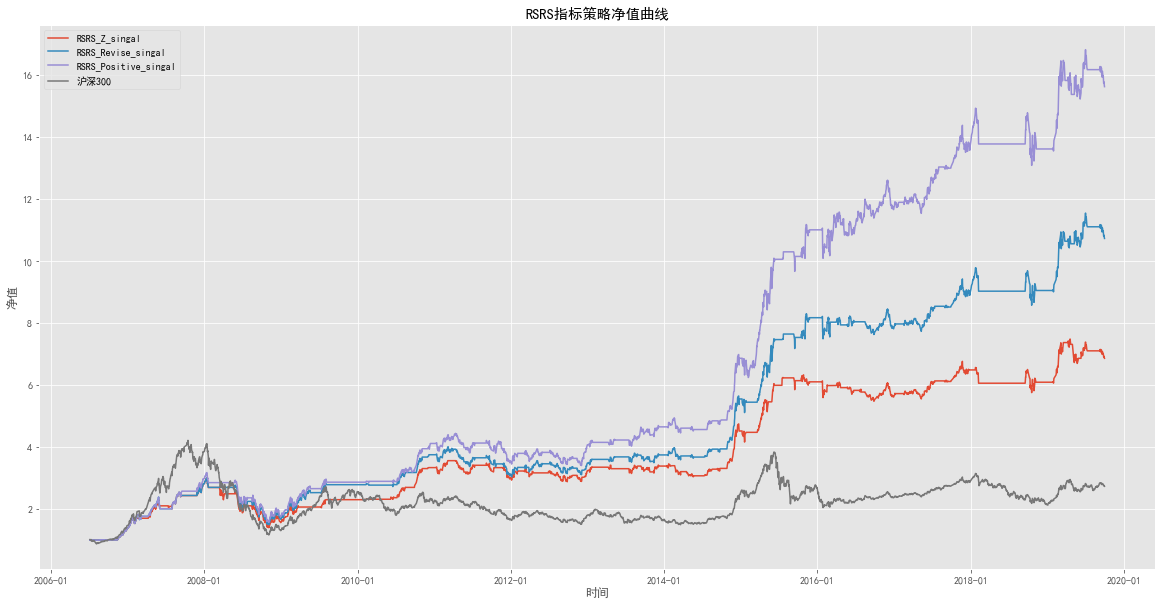

,标准分指标策略,修正标准分策略,右偏标准分策略
年华收益率,16.11%,20.20%,23.75%
累计收益率,586.68%,973.41%,1463.22%
夏普比率,0.877743,1.02538,1.14076
最大回撤,53.36%,50.21%,50.49%
持仓总天数,1495,1654,1895
交易次数,62,51,39
平均持仓天数,24.1129,32.4314,48.5897
获利天数,819,913,1052
亏损天数,676,741,843
胜率(按天),54.78%,55.20%,55.51%


In [89]:
# 右偏标准分择时指标回测
'''
研报中并没把标准分、修正标准分放在同一参数上回测，标准分和修正标准依旧用的原参数(18，600)
在这里我将三个策略放在同一参数下回测
'''
#@pysnooper.snoop()
def RSRS_Positive_Strategy(datas, N, M):
    df = datas.copy()

    RSRS_Z = Cal_RSRS_Positive(df, N, M)  # 计算标准分指标
    
    singal_name=['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise,RSRS_Positive'.split(',')]
    # 需要扣除前期计算的600日
    RSRS_Z = RSRS_Z[max(N, M)-1:]
    
    print('回测起始日：', min(RSRS_Z.index))
    # 获取标准分信号
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Z', 0.7, -0.7)
    # 获取修正标准分
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Revise', 0.7, -0.7)
    # 获取右偏标准分
    RSRS_Z=get_singal(RSRS_Z,'RSRS_Positive',0.7,-0.7)
    
    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()
    
    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    
    # 斜率净值
    for n in singal_name:
        CUM=(1+RSRS_Z[n]*RSRS_Z['ret']).cumprod()
        ax1.plot(CUM,label=n)

    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()
    
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS指标策略净值曲线')
    plt.show()
    
    display(HTML(summary(RSRS_Z,singal_name).to_html()))

# 右偏标准分
RSRS_Positive_Strategy(df,16,300)

策略应用在沪深 300 指数数据上，右偏标准分策略交易 39 次，在不计成本的情况下 13 年总收益 1463.22%，平均年化 23.75%，夏普比1.14， 最大回撤50.49%。 

相比标准分指标策略，右偏标准分指标策略在收益率上有小幅提高。 通过对预测性的优化使得指标择时在预测性与收益上有所提高，但依旧有没有能克服其一开始就存在的缺点：熊市开仓信号误判或过早左侧开仓造成巨大回撤。

回测起始日： 2007-09-24 00:00:00


<Figure size 432x288 with 0 Axes>

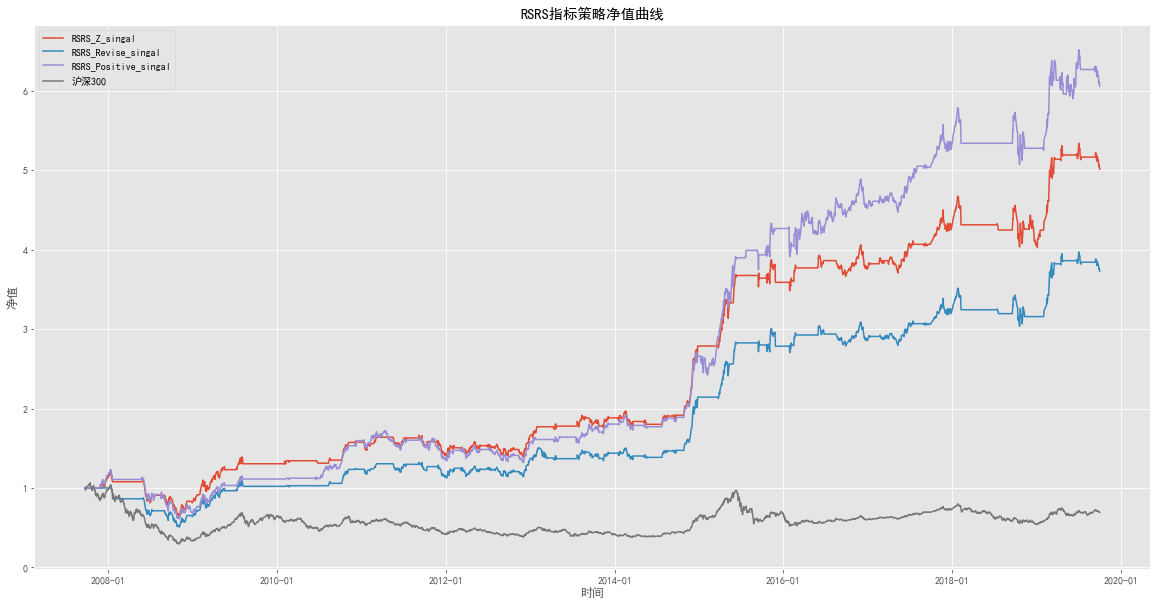

,标准分指标策略,修正标准分策略,右偏标准分策略
年华收益率,14.78%,11.91%,16.64%
累计收益率,401.52%,272.97%,505.78%
夏普比率,0.877936,0.731968,0.876772
最大回撤,46.16%,49.28%,50.49%
持仓总天数,1358,1331,1750
交易次数,48,43,35
平均持仓天数,28.2917,30.9535,50
获利天数,728,709,949
亏损天数,630,622,801
胜率(按天),53.61%,53.27%,54.23%


In [140]:
# 在同等时间长度，不同策略参数下回测
def RSRS_Pam_Strategy(datas):
    df = datas.copy()
    RSRS=Cal_RSRS_Revise(df,18,600)
    RSRS_Z = Cal_RSRS_Positive(df, 16, 300)  # 计算标准分指标
    RSRS_Z.loc[:,['RSRS_Z','RSRS_Revise']]=RSRS.loc[:,['RSRS_Z','RSRS_Revise']]
    
    singal_name=['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise,RSRS_Positive'.split(',')]
    
    # 添加20日均线
    RSRS_Z['MA']=RSRS_Z['close'].rolling(20).mean()
    # 需要扣除前期计算的600日
    RSRS_Z = RSRS_Z[599:]
    
    print('回测起始日：', min(RSRS_Z.index))
    # 获取标准分信号
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Z',0.7,-0.7)
    # 获取修正标准分
    RSRS_Z = get_singal(RSRS_Z, 'RSRS_Revise',0.7,-0.7)
    # 获取右偏标准分
    RSRS_Z=get_singal(RSRS_Z,'RSRS_Positive',0.7,-0.7)

    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()
    
    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    
    # 斜率净值
    for n in singal_name:
        CUM=(1+RSRS_Z[n]*RSRS_Z['ret']).cumprod()
        ax1.plot(CUM,label=n)

    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()
    
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS指标策略净值曲线')
    plt.show()
    
    display(HTML(summary(RSRS_Z,singal_name).to_html()))


# 基于当前市场价格趋势的优化
RSRS_Pam_Strategy(df)

# <font color=DarkMagenta>RSRS指标配合量价数据优化策略</font>

按照阻力支撑相对强度指标的逻辑，<u>*策略大概率是在左侧开仓，左侧平仓*</u>。在<font color=CornFlowerBlue>**做多策略中，左侧开仓预测错误的危害远远大于左侧平仓预测错误的危害**</font>。我们希望策略在保留左侧平仓收益的同时能规避掉在大熊市买入的情 况。我们可以尝试在开仓时，加入一个对目前市场状态的判断，过滤掉左侧开仓，亦即是下跌行情中的开仓。

## <font color=DarkMagenta>基于当前市场价格趋势的优化</font>

一个比较简单的方式是直接从近期历史的价格趋势判断。在回测中，我们使用当日20日均线值与3日前20日均线值的相对大小来判断近期市场状态。

**价格优化交易策略**： 
>
>1. 计算RSRS标准分指标买卖信号。
>2. 如果指标发出买入信号，同时满足前一日 MA(20)的值大于前三日 MA(20)的值，则买入。
>3. 如果指标发出卖出信号，则卖出手中持股。 
>4. （如果可卖空，当指标发出卖出信号，同时满足前一日MA(20)的值 小于前三日MA(20)的值，则卖出。）
>5. （如果可卖空，当指标发出买入信号，则买入平空仓。） 在加入价格过滤后，标准分指标，修正标准分指标以及右偏标准分指标的策略表现都显著提高，成功规避了在大熊市的惨重损失。年化收益，夏普 比率，最大回撤，胜率以及盈亏比优化前有显著提升，净值曲线更加平滑，同时由于通过价格过滤掉一些交易，总交易次数有所减少。

在加入价格过滤后，标准分指标，修正标准分指标以及右偏标准分指标 的策略表现都显著提高，成功规避了在大熊市的惨重损失。夏普比率，最大回撤，胜率以及盈亏比优化前有显著提升，净值曲线更加平滑。(为什么我的交易次数反而增加了

回测起始日： 2006-07-05 00:00:00


<Figure size 432x288 with 0 Axes>

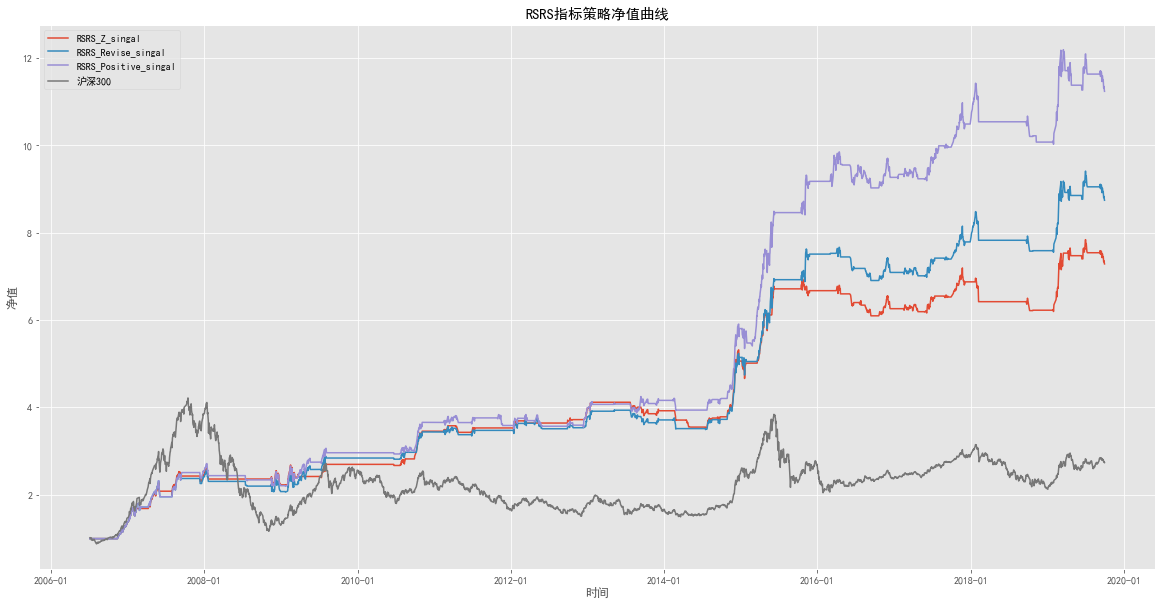

,标准分指标策略,修正标准分策略,右偏标准分策略
年华收益率,16.64%,18.30%,20.62%
累计收益率,628.50%,774.18%,1023.37%
夏普比率,1.20254,1.20769,1.29253
最大回撤,15.81%,19.75%,19.16%
持仓总天数,889,1018,1177
交易次数,57,62,68
平均持仓天数,15.5965,16.4194,17.3088
获利天数,514,593,682
亏损天数,375,425,495
胜率(按天),57.82%,58.25%,57.94%


In [141]:
# 基于市场的优化回测
def RSRS_MA_Strategy(datas,N,M):
    df = datas.copy()
    RSRS_Z = Cal_RSRS_Positive(df, N, M)  # 计算标准分指标
    
    singal_name=['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise,RSRS_Positive'.split(',')]
    
    # 添加20日均线
    RSRS_Z['MA']=RSRS_Z['close'].rolling(20).mean()
    # 需要扣除前期计算的600日
    RSRS_Z = RSRS_Z[max(N,M)-1:]
    
    print('回测起始日：', min(RSRS_Z.index))
    # 获取标准分信号
    RSRS_Z = Add_MA(RSRS_Z, 'RSRS_Z')
    # 获取修正标准分
    RSRS_Z = Add_MA(RSRS_Z, 'RSRS_Revise')
    # 获取右偏标准分
    RSRS_Z=Add_MA(RSRS_Z,'RSRS_Positive')

    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()
    
    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    
    # 斜率净值
    for n in singal_name:
        CUM=(1+RSRS_Z[n]*RSRS_Z['ret']).cumprod()
        ax1.plot(CUM,label=n)

    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()
    
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS指标策略净值曲线')
    plt.show()
    
    display(HTML(summary(RSRS_Z,singal_name).to_html()))

# 添加均值条件    
def Add_MA(datas,singal_name):
    df=datas.copy()
    # 前三日
    df['shift_3']=df['MA'].shift(3)
    # 前一日
    df['shift_1']=df['MA'].shift(1)
    # 设置参数
    df=get_singal(df,singal_name,0.7,-0.7)
    
    df[singal_name+'_singal']=(df['shift_1']>df['shift_3'])&(df[singal_name+'_singal']==1)
    datas[singal_name+'_singal']=df[singal_name+'_singal']
    return datas

# 基于当前市场价格趋势的优化
RSRS_MA_Strategy(df,16,300)

## <font color=DarkMagenta>基于RSRS指标与交易量相关性的优化</font>

继续从标准分策略误判下跌见底的现象分析。除却直接从近期历史价格来确认当下市场趋势状态，很多发表的研究表明市场涨跌与交易量有明显的 正相关性。借鉴类似的想法，我们尝试用交易量与修正标准分之间的相关性 来过滤误判信号。只有在相关性为正的时刻给出的交易信号，我们才认为是 合理的信号。

交易量相关性优化交易策略： 

>1. 计算RSRS标准分指标买卖信号。 
>2. 如果指标发出买入信号，同时满足前 10 日交易量与修正标准分之间 的相关性为正，则买入。
>3. 如果指标发出卖出信号，则卖出手中持股。
>4. （如果可卖空，当指标发出卖出信号，同时满足交易量与修正标准分 之间的相关性为正，则卖出。）
>5. （如果可卖空，当指标发出买入信号，则买入平空仓。） 通过回测统计数据，交易量相关性相比于价格过滤掉了更多的交易，也成功避开了熊市市场，夏普比率，平均盈亏比与最大回撤有了些许提升，但 在收益率上即使考虑到成本因素也不如价格优化的结果。同时交易量相关性 优化后的各RSRS 标准分指标策略的最终净值几乎一致；除去右偏策略的最大回撤稍大以外，其它统计数据也相差不多。

回测起始日： 2006-07-05 00:00:00


<Figure size 432x288 with 0 Axes>

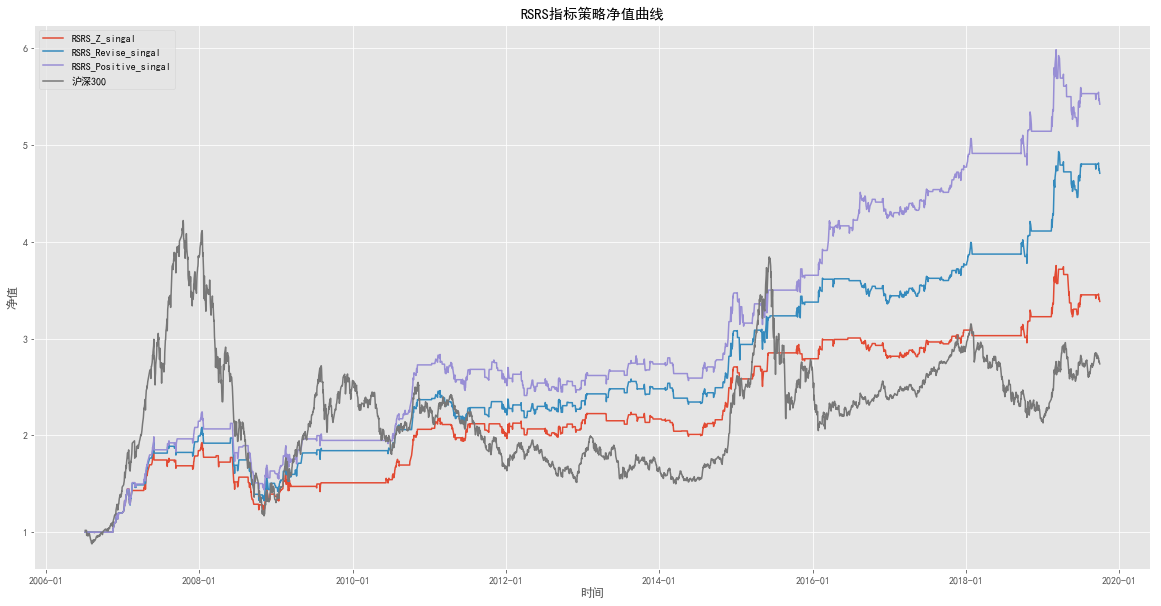

,标准分指标策略,修正标准分策略,右偏标准分策略
年华收益率,9.91%,12.76%,14.00%
累计收益率,238.32%,370.70%,442.10%
夏普比率,0.739672,0.907713,0.959677
最大回撤,36.28%,36.40%,35.93%
持仓总天数,795,877,987
交易次数,151,154,168
平均持仓天数,5.2649,5.69481,5.875
获利天数,438,493,556
亏损天数,357,384,431
胜率(按天),55.09%,56.21%,56.33%


In [136]:
# 基于交易量优化
def RSRS_Volume_Strategy(datas, N, M):
    df = datas.copy()

    RSRS_Z = Cal_RSRS_Positive(df, N, M)  # 计算标准分指标
    
    singal_name=['{}_singal'.format(x) for x in 'RSRS_Z,RSRS_Revise,RSRS_Positive'.split(',')]
    
    # 需要扣除前期计算的600日
    RSRS_Z = RSRS_Z[max(N, M)-1:]
    
    print('回测起始日：', min(RSRS_Z.index))
    # 获取标准分信号
    RSRS_Z = Add_Amount(RSRS_Z, 'RSRS_Z')
    # 获取修正标准分
    RSRS_Z = Add_Amount(RSRS_Z, 'RSRS_Revise')
    # 获取右偏标准分
    RSRS_Z=Add_Amount(RSRS_Z,'RSRS_Positive')

    # 收益
    RSRS_Z['ret'] = RSRS_Z['close'].pct_change()
    
    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    
    # 斜率净值
    for n in singal_name:
        CUM=(1+RSRS_Z[n]*RSRS_Z['ret']).cumprod()
        ax1.plot(CUM,label=n)

    # 基准净值
    benchmark = (1+RSRS_Z['ret']).cumprod()
    
    ax1.plot(benchmark, label='沪深300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS指标策略净值曲线')
    plt.show()
    
    display(HTML(summary(RSRS_Z,singal_name).to_html()))

# 添加均值条件    
def Add_Amount(datas,singal_name):
    df=datas.copy()
    # 获取10日滚动相关系数
    df['corr']=df['volume'].rolling(10).corr(df[singal_name]).shift(1)
    # 设置参数
    df=get_singal(df,singal_name,0.7,-0.7)
    
    df[singal_name+'_singal']=(df['corr']>0)&(df[singal_name+'_singal']==1)
    datas[singal_name+'_singal']=df[singal_name+'_singal']
    return datas

# 基于当前市场价格趋势的优化
RSRS_Volume_Strategy(df,16,300)

# <font color=DarkMagenta>M期敏感性分析</font>

>在基于量价数据的配合下，策略表现有所提高。同时为了比较策略基于不同优化方式的择时效果，我们选取了同样的参数（N=18,M=600,S=0.7）。 现在我们检查不同策略对于参数选取的敏感性。 对于标准分计算周期M，开始我们的预期是M值越大，标准分的计算所用数据越多，择时效果可能越好。然而我们发现在超过 600后基本上净值开始单调递减。有两个较为可能的原因，第一个是市场整体环境只在一定时间内相对稳定，例如 2 年前的市场与当下的市场的基本面已然改变，使用更多过远历史的数据来计算标准分未必能改善信号质量。第二个原因是由于参数 M太大，会使回测前期的信号相对不稳地：例如如若M=600，那么在回测中前 600 天并没有600个斜率数据来计算标准分，**比如回测第 50 天就只使用了 50 个斜率数据计算标准分指标。事实上，我们仔细观察回测数据。发现的确在策略在前期，标准分信号波动很大，对策略产生影响。**

ps：<font color=Darkred>**感觉找到了与研报计算部分结论不同的原因 当M=600时rolling函数在前面有600个数据时才开始计算 如果根据最好一段话所说的那样，当数据<600时的计算肯定与我的计算结果有出入**</font>

In [148]:
# 敏感性分析
def Threshold_Analyze(datas, N, M=range(400, 850, 50)):

    df = datas.copy()
    singal_name = 'RSRS_Z,RSRS_Revise,RSRS_Positive'.split(',')
    summary_dic = {}  # 储存每期净值均值
    temp = []  # 中间过程

    # 计算收益率
    df['ret'] = df['close'].pct_change()
    # 计算均线
    df['MA']=df['close'].rolling(20).mean()

    for m in M:
        # 计算基础指标
        RSRS_Z = Cal_RSRS_Positive(df, N, m)

        D_CUM = []  # 储存单指标净值
        M_CUM = []  # 储存价格优化净值
        V_CUM = []  # 储存相关性优化净值

        for n in singal_name:

            # 单指标净值
            RSRS_D = get_singal(RSRS_Z, n, 0.7, -0.7)
            D_CUM.append((1+RSRS_D[n+'_singal']*RSRS_D['ret']).cumprod()[-1])

            # 价格优化净值
            RSRS_M = Add_MA(RSRS_Z, n)
            M_CUM.append((1+RSRS_M[n+'_singal']*RSRS_M['ret']).cumprod()[-1])

            # 相关性优化净值
            RSRS_V = Add_MA(RSRS_Z, n)
            V_CUM.append((1+RSRS_V[n+'_singal']*RSRS_V['ret']).cumprod()[-1])

        summary_dic['单指标净值'] = np.mean(D_CUM)
        summary_dic['价格优化净值'] = np.mean(M_CUM)
        summary_dic['相关性优化净值'] = np.mean(V_CUM)

        temp.append(pd.Series(summary_dic))

    summary_df = pd.concat(temp,axis=1).T
    summary_df.index = M
    summary_df.index.names = ['参数值M']

    return summary_df


# 敏感性分析报告
Threshold_Analyze(df, 18, M=range(200, 850, 50))

,单指标净值,价格优化净值,相关性优化净值
参数值M,,,
200,8.898869,8.661415,8.661415
250,7.929221,9.043516,9.043516
300,8.859625,8.037107,8.037107
350,8.725649,7.697796,7.697796
400,6.913854,6.402087,6.402087
450,4.867505,4.559669,4.559669
500,5.105102,4.783874,4.783874
550,4.747956,4.397224,4.397224
600,4.054526,3.646946,3.646946
